### colab

In [1]:
import os
colab = os.getcwd() == "/content"
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# drive.flush_and_unmount()  # Smonta Google Drive
# drive.mount('/content/drive', force_remount=True)  # Rimonta


### import

In [3]:
# !mpirun --allow-run-as-root --map-by slot:OVERSUBSCRIBE -np 4 python3 ns_dolfinx.py


In [4]:
from __future__ import print_function


In [5]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import copy
import tqdm.autonotebook
from tqdm import tqdm
from scipy.interpolate import RBFInterpolator
import pickle

<ipython-input-5-3ac0b30d2ee8>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook


In [6]:
from IPython.display import clear_output as clc
plt.style.use("default")
%config InlineBackend.figure_format = 'retina'

In [7]:
import seaborn as sns
from matplotlib import colors
ice = sns.color_palette("icefire", as_cmap=True).colors
col = [ice[i] for i in np.concatenate((np.arange(128,0,-10), np.arange(254,128,-9)))]
col.insert(0, "black")
cmap = colors.LinearSegmentedColormap.from_list("", col)

In [8]:
def add_zoom(zoom = 1.5, dpi = 100):
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)
    plt.gcf().dpi = dpi

In [9]:
def scatter_array(arr, label = "label", leg = False, zoom = 1, dpi = 100, s=None, c = None, marker=None):

    plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s, c = c, marker=marker)
    add_zoom(zoom, dpi = dpi)
    plt.gca().set_aspect("equal")
    plt.gca().set_adjustable("box")

    if leg:
        plt.gca().legend(loc = "upper right")
    # plt.show()

In [10]:
if colab:
    os.chdir("/content/drive/MyDrive/mySHRED")

In [11]:
# naca0012_data = np.load("data/naca0012_data.npz")
# naca0012_coords = naca0012_data['naca0012_coords']
# naca0012_airfoil_coords = naca0012_data['naca0012_airfoil_coords']

In [12]:
L = 20
H = 20

R = 0.5
l = 3*R
centers = [[0.25*L, H/2],
           [0.25*L + l*(np.sqrt(3)/2), H/2 + l/2],
           [0.25*L + l*(np.sqrt(3)/2), H/2 - l/2]]

dt = 0.01
T = 10
timesteps = int(T/dt)

rho_ = 1
U_max = 3

save_to_np_every_steps = 1
ntimes = timesteps // save_to_np_every_steps + 1 # initial condition

### Utilities

In [13]:
def generate_airfoil(m=0.02, p=0.4, t=0.12, n_points=100, x_le = 0.0, y_le = 0.0):
    """
    Genera un profilo alare tipo NACA-like con parametri semplificati.

    Args:
        m: massimo camber (es. 0.02 = 2%)
        p: posizione del camber (0-1, frazione della corda)
        t: spessore massimo (es. 0.12 = 12%)
        n_points: numero di punti (metà superiore)

    Returns:
        x: array di coordinate x
        y_upper: array dell’estradosso
        y_lower: array dell’intradosso
    """

    # x = np.linspace(0, 1, n_points)
    x = (1 - np.cos(np.linspace(0, 1, int(np.ceil(n_points/2)))*np.pi)) / 2

    # Curva camber
    yc = np.where(x < p,
                  m / p**2 * (2*p*x - x**2),
                  m / (1 - p)**2 * ((1 - 2*p) + 2*p*x - x**2))

    # Derivata del camber
    dyc_dx = np.where(x < p,
                      2*m / p**2 * (p - x),
                      2*m / (1 - p)**2 * (p - x))
    theta = np.arctan(dyc_dx)

    # Spessore (classica formula NACA 4-digit)
    yt = 5 * t * (0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - 0.1015*x**4)

    # Coordinate superiori e inferiori
    x_upper = x - yt * np.sin(theta)
    y_upper = yc + yt * np.cos(theta)
    x_lower = x + yt * np.sin(theta)
    y_lower = yc - yt * np.cos(theta)

    # Unione dei punti per profilo completo
    x_coords = np.concatenate([x_upper[::-1], x_lower[1:]])
    y_coords = np.concatenate([y_upper[::-1], y_lower[1:]])

    return np.concatenate((x_coords.reshape(-1,1) + x_le, y_coords.reshape(-1,1) + y_le), axis = 1)

def generate_airfoil_random(chord = 1, n_points=100, x_le = 0.0, y_le = 0.0):
    m = np.random.rand() * 0.05 * chord
    p = (np.random.rand() * 0.3 + 0.3) * chord
    t = (np.random.rand() * 0.06 + 0.09) * chord

    return generate_airfoil(m, p, t, n_points, x_le, y_le)


In [14]:
from matplotlib import pyplot as plt
import matplotlib.tri as tri
import numpy as np

def order_polygon(xy_points):
    """
    Orders a set of unordered polygon points into a counterclockwise sequence.
    """
    xy_points = np.array(xy_points, dtype=np.float32)

    # Compute the centroid (average of all points)
    centroid = np.mean(xy_points, axis=0)

    # Compute angles relative to centroid
    angles = np.arctan2(xy_points[:, 1] - centroid[1], xy_points[:, 0] - centroid[0])

    # Sort points by angle in counterclockwise order
    sorted_indices = np.argsort(angles)
    ordered_points = xy_points[sorted_indices]

    return ordered_points

def point_in_obstacle(xy_points, xy_obstacle):
    """
    Determine if points are inside the NACA 0012 airfoil using JAX.
    """
    xy_points = np.array(xy_points, dtype=np.float32)
    ordered_xy_obstacle = order_polygon(xy_obstacle)
    obstacle_x, obstacle_y = ordered_xy_obstacle[:, 0], ordered_xy_obstacle[:, 1]

    x_pts = xy_points[:, 0]
    y_pts = xy_points[:, 1]

    # Roll the obstacle boundary to get pairs of consecutive points
    x1, y1 = obstacle_x, obstacle_y
    x2, y2 = np.roll(obstacle_x, shift=-1, axis=0), np.roll(obstacle_y, shift=-1, axis=0)

    # Conditions for ray intersection with edges
    intersects = np.logical_and(
        np.logical_or(y1 <= y_pts[:, None], y2 <= y_pts[:, None]),
        np.logical_or(y1 > y_pts[:, None], y2 > y_pts[:, None]),
    )

    # Compute intersection x-coordinates using vectorized form
    denom = (y2 - y1) + 1e-9  # Avoid division by zero
    x_intersect = x1 + (y_pts[:, None] - y1) * (x2 - x1) / denom

    # Check if x-coordinates of the intersection are greater than x_pts
    inside = np.sum(
        np.where(np.logical_and(intersects, x_pts[:, None] < x_intersect), 1, 0), axis=1
    )

    # If count of intersections is odd, point is inside
    return inside % 2 == 1

In [15]:
def interpolate_coords(coords, control_points, displacements):
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(coords[:, :2])
    new_coords = coords[:, :2] + displacements
    return new_coords

In [16]:
def get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = 10.0, y1 = 4.0, each = 2, step_size = 0.05):

    N_points = airfoil_coords.shape[0]
    # print(N_points)
    airfoil_control_points_ids = np.arange(0, N_points, each).tolist()
    # print(airfoil_control_points_ids.shape)
    # print(airfoil_control_points_ids)
    airfoil_control_points = airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])
    new_airfoil_control_points = new_airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])

    airfoil_displacements = np.array(new_airfoil_control_points - airfoil_control_points)

    wall1_points = np.concatenate((np.arange(x0, x1, step_size).reshape(-1,1), np.zeros(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall2_points = np.concatenate((x1 * np.ones(round(y1/step_size)).reshape(-1,1), np.arange(y0, y1, step_size).reshape(-1,1)), axis = 1)
    wall3_points = np.concatenate((np.arange(x1, x0, -step_size).reshape(-1,1), y1 * np.ones(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall4_points = np.concatenate((np.zeros(round(y1/step_size)).reshape(-1,1), np.arange(y1, y0, -step_size).reshape(-1,1)), axis = 1)

    control_points = np.concatenate((airfoil_control_points, wall1_points, wall2_points, wall3_points, wall4_points), axis = 0)
    displacements = np.concatenate((airfoil_displacements, np.zeros((wall1_points.shape[0] + wall2_points.shape[0] + wall3_points.shape[0] + wall4_points.shape[0], 2))), axis = 0)

    return control_points, displacements


In [17]:
# def update_coords_and_triang(params, coords = naca0012_coords, airfoil_coords = naca0012_airfoil_coords):

#     N_points = airfoil_coords.shape[0]
#     new_airfoil_coords = generate_airfoil(params[0].item(), params[1].item(), params[2].item(), n_points = N_points, x_le = x_le, y_le = y_le)
#     control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
#     coords = interpolate_coords(coords, control_points, displacements)
#     x, y = coords[:, 0], coords[:, 1]
#     triang = tri.Triangulation(x, y)
#     x_tri = x[triang.triangles].mean(axis=1)
#     y_tri = y[triang.triangles].mean(axis=1)
#     mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(new_airfoil_coords[:, 0], new_airfoil_coords[:, 1]))])
#     triang.set_mask(mask)

#     return coords, triang

In [18]:
# from scipy.spatial import cKDTree

# def extract_sensor_indices_pinball(xy, centers, R, nsensors, dist_min, dist_edge=0.0):
#     """
#     Seleziona indici di sensori da una mesh per simulazioni su un profilo alare.

#     Parametri
#     --------
#     xy : ndarray di shape (n_nodes, 3)
#         Coordinate del mesh su [xmin, xmax] x [ymin, ymax], con z sempre zero.
#     boundary_coords : ndarray di shape (n_boundary, 3)
#         Coordinate dei nodi sul contorno dell'airfoil.
#     nsensors : int
#         Numero totale di sensori da selezionare.
#     dist_min : float
#         Distanza minima richiesta tra coppie di sensori.
#     dist_edge : float, opzionale
#         Distanza minima da rispettare fra ogni sensore (esclusi LE e TE) e i punti LE/TE.
#         Default 0.

#     Ritorna
#     -------
#     sensor_indices : ndarray di shape (nsensors,)
#         Indici nel mesh selezionati come sensori.
#     """


#     boundary_xy = boundary_coords[:, :2]
#     tree_boundary = cKDTree(boundary_xy)
#     dist_to_airfoil, _ = tree_boundary.query(xy)

#     # Near-field: punti entro una corda dal profilo
#     near_field = dist_to_airfoil <= chord * 0.6

#     # Intervallo y del near-field
#     y_vals = xy[near_field, 1]
#     y_min, y_max = y_vals.min(), y_vals.max()

#     # Wake: downstream del trailing edge e all'interno del range y
#     wake = (xy[:, 0] > te_coord[0]) & (xy[:, 1] >= y_min) & (xy[:, 1] <= y_max)

#     # Regione di interesse
#     region_mask = near_field | wake

#     # Indici candidati (escludi LE e TE)
#     candidates = np.nonzero(region_mask)[0]
#     candidates = candidates[(candidates != idx_le) & (candidates != idx_te)]

#     # Escludi punti troppo vicini a LE o TE
#     if dist_edge > 0:
#         d_le = np.linalg.norm(xy[candidates] - le_coord, axis=1)
#         d_te = np.linalg.norm(xy[candidates] - te_coord, axis=1)
#         mask_edge = (d_le >= dist_edge) & (d_te >= dist_edge)
#         candidates = candidates[mask_edge]

#     # Selezione casuale con vincolo di distanza minima
#     rng = np.random.default_rng()
#     shuffled = rng.permutation(candidates)
#     selected = []
#     for idx in shuffled:
#         p = xy[idx]
#         if all(np.linalg.norm(p - xy[j]) >= dist_min for j in selected):
#             selected.append(idx)
#             if len(selected) >= nsensors - 2:
#                 break

#     if len(selected) < nsensors - 2:
#         raise ValueError(f"Impossibile selezionare {nsensors} sensori: aumentare regione o diminuire dist_min o dist_edge.")

#     # Aggiungi LE e TE
#     sensor_indices = np.hstack(([idx_le, idx_te], selected[:nsensors-2]))
#     return sensor_indices

In [19]:
def extract_sensor_indices_pinball(xy, centers, R, nsensors, dist_min, dist_edge=0.0):

    # 1) Calcolo distanza di ogni punto dai 3 centri
    #    dist_matrix[i,j] = distanza tra xy[i] e centers[j]
    dist_matrix = np.linalg.norm(xy[:, None, :] - centers[None, :, :], axis=2)

    # 2) Near-field: punti a distanza max 2R da uno dei cilindri
    near_field = (dist_matrix <= 2*R).any(axis=1)

    # 3) Intervallo y del near-field
    y_vals = xy[near_field, 1]
    if y_vals.size == 0:
        raise ValueError("Nessun punto nella near-field: controlla R o la mesh.")
    y_min, y_max = y_vals.min(), y_vals.max()

    # 4) Wake: regione downstream del lato destro di tutti i cilindri
    te_x = centers[:, 0].max()
    wake = (xy[:, 0] > te_x) & (xy[:, 1] >= y_min) & (xy[:, 1] <= y_max)

    # 5) Regione di interesse
    region_mask = near_field | wake
    candidates = np.nonzero(region_mask)[0]

    # 6) Escludi punti troppo vicini alla superficie dei cilindri
    if dist_edge > 0:
        # distanza al contorno: |dist_to_center - R|
        d_to_surface = np.abs(dist_matrix[candidates, :] - R)
        # per ogni punto prendo la distanza minima da QUALSIASI cilindro
        min_d_surf = d_to_surface.min(axis=1)
        candidates = candidates[min_d_surf >= dist_edge]
        if candidates.size == 0:
            raise ValueError("Nessun candidato dopo aver applicato dist_edge; riduci dist_edge o allarga regione.")

    # 7) Selezione casuale con vincolo di distanza minima
    rng = np.random.default_rng()
    perm = rng.permutation(candidates)
    selected = []
    for idx in perm:
        p = xy[idx]
        if all(np.linalg.norm(p - xy[j]) >= dist_min for j in selected):
            selected.append(idx)
            if len(selected) >= nsensors:
                break

    if len(selected) < nsensors:
        raise ValueError(
            f"Impossibile selezionare {nsensors} sensori: "
            "aumenta la regione di ricerca, diminuisci dist_min o dist_edge."
        )

    return np.array(selected, dtype=int)

# SHRED-ROM

### Positional encoding

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# train_trajectories = len(idx_train)
# train_trajectories

In [22]:
# sensors_coords_new = torch.from_numpy(sensors_coords_new)
# XY = torch.from_numpy(XY)
# Vxtrain = torch.from_numpy(Vxtrain)

In [23]:
import torch
import torch.nn.functional as F

# --------------------------------------------------
# 1. Definizione della funzione di Fourier Positional Encoding
# --------------------------------------------------
def fourier_encode(x, B):
    """
    Applica il positional encoding Fourier alle coordinate.

    Parametri:
      - x: tensor di shape (n, d) (ad esempio, coordinate spaziali)
      - B: tensor di shape (d, D) contenente le frequenze.

    Restituisce:
      - encoding: tensor di shape (n, 2*D) ottenuto concatenando sin(xB) e cos(xB).
    """
    # Proiezione: x @ B produce un tensore di shape (n, D)
    x_proj = 2 * torch.pi * x @ B
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# --------------------------------------------------
# 2. Setup dei parametri e degli input
# --------------------------------------------------
d = 2   # dimensione originale delle coordinate (x, y)
D = 16  # dimensione scelta per la proiezione (puoi variare questo parametro)

# Matrice di frequenze per il Fourier encoding (può essere fissata oppure resa learnable)
B = torch.randn(d, D).to(device)

# # --------------------------------------------------
# # 3. Calcolo degli encoding Fourier per i nodi e per i sensori
# # --------------------------------------------------
# # Calcolo dell'encoding per i sensori: shape (nsensors, 2*D)
# sensor_encodings = fourier_encode(sensors_coords_new, B)  # comune a tutte le traiettorie

# # Calcolo dell'encoding per i nodi per tutte le traiettorie.
# # Risultato atteso: (ntraj, nvelocity, 2*D)
# # Possiamo calcolarlo in modo vettorizzato:
# node_encodings_train = fourier_encode(XY[idx_train].view(-1, d), B)
# node_encodings_train = node_encodings_train.view(len(idx_train), nvelocity, 2 * D)

# node_encodings_valid = fourier_encode(XY[idx_valid].view(-1, d), B)
# node_encodings_valid = node_encodings_valid.view(len(idx_valid), nvelocity, 2 * D)

# node_encodings_test = fourier_encode(XY[idx_test].view(-1, d), B)
# node_encodings_test = node_encodings_test.view(len(idx_test), nvelocity, 2 * D)

In [24]:
# # --------------------------------------------------
# # 4. Calcolo dei pesi di similarità e interpolazione
# # --------------------------------------------------
# # Per ogni traiettoria, calcoliamo la similarità fra i sensori e i nodi.
# # Usiamo broadcasting per ottenere in una sola operazione:
# #
# #   sensor_encodings: (nsensors, 2*D)
# #   node_encodings: (ntraj, nvelocity, 2*D)
# #
# # Vogliamo ottenere similarity: (ntraj, nsensors, nvelocity)
# # facendo, per ogni traiettoria i e per ogni sensore j,
# #   similarity[i,j] = sensor_encodings[j] · node_encodings[i].T
# sensor_encodings_expanded = sensor_encodings.unsqueeze(0)  # shape: (1, nsensors, 2*D)


In [25]:
# # Trasponiamo l'encoding dei nodi per il prodotto scalare:
# node_encodings_t = node_encodings_train  # shape: (ntraj, nvelocity, 2*D)
# similarity = torch.matmul(sensor_encodings_expanded, node_encodings_t.transpose(1,2))
# # similarity: (ntraj, nsensors, nvelocity)

# # Otteniamo i pesi (softmax sul nodo-dimensione, ovvero dim=2)
# weights = F.softmax(similarity, dim=2)  # shape: (ntraj, nsensors, nvelocity)

# # Ora, per ogni traiettoria e per ogni timestep, eseguiamo la media pesata dei valori dei nodi.
# # Vxtrain ha shape: (ntraj, ntimes, nvelocity)
# # Per eseguire la moltiplicazione, trasponiamo weights in modo che abbiano shape (ntraj, nvelocity, nsensors)
# weights_t = weights.transpose(1,2)  # shape: (ntraj, nvelocity, nsensors)


In [26]:

# # Reshape Vxtrain per includere una dimensione batch 3D: (ntraj*ntimes, 1, nvelocity)
# Vxtrain_reshaped = Vxtrain.view(-1, nvelocity).unsqueeze(1)

# # Replichiamo i pesi per ogni timestep all'interno della traiettoria:
# # weights_t ha shape: (ntraj, nvelocity, nsensors)
# # Ripetiamo ogni matrice di pesi ntimes volte lungo l'asse batch:
# weights_expanded = weights_t.repeat_interleave(ntimes, dim=0)  # shape: (ntraj*ntimes, nvelocity, nsensors)


In [27]:
# # Ora possiamo fare la moltiplicazione batch-matrix:
# Vx_interp_flat = torch.bmm(Vxtrain_reshaped, weights_expanded)  # shape: (ntraj*ntimes, 1, nsensors)
# # Rimuoviamo la dimensione 1 e rimodelliamo:
# sensors_data_train = Vx_interp_flat.squeeze(1).view(train_trajectories, ntimes, nsensors)


In [28]:
# # ad ogni step:
# # - genero sensor_coords_new
# sensor_encodings_expanded = fourier_encode(sensors_coords_new, B).unsqueeze(0)  # shape: (1, nsensors, 2*D)

# # - per train, valid e test:
# similarity = torch.matmul(sensor_encodings_expanded, node_encodings_t.transpose(1,2))
# weights_t = F.softmax(similarity, dim=2).transpose(1,2)  # shape: (ntraj, nvelocity, nsensors)
# weights_expanded = weights_t.repeat_interleave(ntimes, dim=0)  # shape: (ntraj*ntimes, nvelocity, nsensors)
# sensors_data_flat = torch.bmm(Vxtrain_reshaped, weights_expanded)  # shape: (ntraj*ntimes, 1, nsensors)
# sensors_data = Vx_interp_flat.squeeze(1).view(train_trajectories, ntimes, nsensors)

In [29]:
# def generate_sensor_data(sensors_coords_new, B):

    # sensor_encodings_expanded = fourier_encode(sensors_coords_new, B).unsqueeze(0)  # shape: (1, nsensors, 2*D)

    # # - per train, valid e test:
    # similarity = torch.matmul(sensor_encodings_expanded, node_encodings_t.transpose(1,2))
    # weights_t = F.softmax(similarity, dim=2).transpose(1,2)  # shape: (ntraj, nvelocity, nsensors)
    # weights_expanded = weights_t.repeat_interleave(ntimes, dim=0)  # shape: (ntraj*ntimes, nvelocity, nsensors)
    # sensors_data_flat = torch.bmm(Vxtrain_reshaped, weights_expanded)  # shape: (ntraj*ntimes, 1, nsensors)
    # sensors_data = Vx_interp_flat.squeeze(1).view(train_trajectories, ntimes, nsensors)

In [30]:
# scatter_array(naca0012_coords, s = 0.1)
# scatter_array(sensors_coords_new, s = 50)
# add_zoom()

In [31]:
# # TRAJECTORY WITH SENSORS (PLOT)
# import matplotlib as mpl

# def trajectory_with_sensors(vt, params_geo, sensors_coordinates, sensors_values, title = None):
#     """
#     Velocity trajectory with sensors
#     Input: velocity trajectory with dimension (ntimes, nvelocity), geometric parameters and and the selected sensor indices
#     """
#     # redefine plot_v on new triang
#     coords, triang = update_coords_and_triang(params_geo)
#     norm = mpl.colors.Normalize(vmin = vt.min().item(), vmax = vt.max().item())
#     def plot_v(v, triang = triang):
#         plt.tricontourf(triang, v, cmap = cmap, levels = 200, norm = norm)
#         plt.gca().set_aspect("equal")
#         add_zoom(zoom = 1.3)

#     # sensors_coordinates = coords[idx_sensors, :2]
#     nsensors = sensors_coordinates.shape[0]

#     for i in range(vt.shape[0]):
#         plt.figure(figsize=(10,10))
#         plot_v(vt[i])
#         for k in np.arange(nsensors):
#             plt.scatter(sensors_coordinates[k, 0], sensors_coordinates[k, 1], c = sensors_values[i, k],
#                         facecolors='none',   # interno trasparente
#                         edgecolors='white',
#                         marker = 'o', norm = norm, s = 100, cmap = cmap) # , mec = 'black', ms = 8, mew = 1.5)
#         plt.xlim((-0.1,10.1))
#         plt.title(title)
#         plt.axis('off')
#         display(plt.gcf())
#         plt.close()
#         clc(wait=True)

# whichtrajectory = 3
# whichtimes = np.arange(0, 200, 10)

# trajectory_with_sensors(Vxtrain[whichtrajectory, whichtimes],
#                         MUtrain[whichtrajectory, 0, 2:],
#                         sensors_coordinates=sensors_coords.detach().numpy(),
#                         sensors_values= sensors_data_train.detach().numpy()[whichtrajectory, whichtimes],
#                         title = "Velocity trajectory with sensors")

### Sensor interpolation

In [32]:
class SensorDataInterpolator(torch.nn.Module):
    def __init__(self, B, device = device):
        """
        XY: torch.Tensor di shape (ntraj, nvelocity, 2) -> coordinate dei nodi per traiettoria
        Vxtrain: torch.Tensor di shape (ntraj, ntimes, nvelocity) -> valori sui nodi (statici nel tempo)
        B: torch.Tensor di shape (2, D) -> matrice di frequenze per il Fourier encoding
        """
        super().__init__()
        self.B = B
        self.device = device

    def forward(self, sensors_coords, Vxtrain, node_encodings):
        """
        sensors_coords: torch.Tensor di shape (nsensors, 2  D) (trainable)

        Restituisce:
           sensor_data: tensor di shape (ntraj, ntimes, nsensors) ottenuto come interpolazione differenziabile
           dei valori Vxtrain nei nuovi punti dati dai sensors_coords_encoded.
        """

        ntraj, nvelocity, ntimes = Vxtrain.shape

        nsensors = sensors_coords.shape[0]
        # Calcola l'encoding dei sensori
        sensor_encodings = fourier_encode(sensors_coords, self.B).to(self.device)  # shape: (nsensors, 2*D)
        # node_encodings: (ntraj, nvelocity, 2*D); vogliamo il prodotto scalare tra
        # ogni sensore ed ogni nodo per ogni traiettoria.
        # Risulta una similarità di shape: (ntraj, nsensors, nvelocity)

        # nsensors = sensor_encodings.shape[0]

        sensor_encodings_expanded = sensor_encodings.unsqueeze(0)  # (1, nsensors, 2*D)
        similarity = torch.matmul(sensor_encodings_expanded, node_encodings.transpose(1,2)).to(self.device)

        # Softmax lungo l'asse dei nodi per ottenere i pesi
        weights = F.softmax(similarity, dim=2).to(self.device)  # shape: (ntraj, nsensors, nvelocity)
        # Per eseguire la somma pesata sui valori:
        # Vxtrain: (ntraj, ntimes, nvelocity)
        # Per la moltiplicazione batch, bisogna trasporre i pesi: (ntraj, nvelocity, nsensors)
        weights_t = weights.transpose(1,2)  # (ntraj, nvelocity, nsensors)

        sensor_vals = torch.matmul(Vxtrain, weights_t).to(self.device)

        return sensor_vals

In [33]:
class ReflectWithGradFlip(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, L, H):
        """
        input: tensor di shape (n, 2), coordinate dei sensori.
        L, H: valori scalari (float) dei limiti per x ed y.
        """
        # Salviamo l'input in ctx per poterlo usare in backward.
        ctx.save_for_backward(input)
        ctx.L = L
        ctx.H = H

        # Calcoliamo il valore riflesso per x e y.
        # Usiamo la formula: r(x) = L - | L - (x mod (2L)) |
        x = input[:, 0]
        y = input[:, 1]
        # Calcoliamo "modulo" con torch.remainder
        r_x = L - torch.abs(L - torch.remainder(x, 2 * L))
        r_y = H - torch.abs(H - torch.remainder(y, 2 * H))
        output = torch.stack([r_x, r_y], dim=1)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # Recupera l'input originale
        input, = ctx.saved_tensors
        L = ctx.L
        H = ctx.H

        # Inizializza il gradiente per input con quello in grad_output
        grad_input = grad_output.clone()

        # Definisci maschere per le coordinate fuori dai limiti:
        mask_x = (input[:, 0] < 0) | (input[:, 0] > L)
        mask_y = (input[:, 1] < 0) | (input[:, 1] > H)
        # Inverte il segno del gradiente nelle coordinate fuori dai limiti:
        grad_input[:, 0] = torch.where(mask_x, -grad_input[:, 0], grad_input[:, 0])
        grad_input[:, 1] = torch.where(mask_y, -grad_input[:, 1], grad_input[:, 1])
        # Non generiamo gradiente per L o H (None)
        return grad_input, None, None

def reflect_with_grad_flip(x, L, H):
    """
    Funzione wrapper per applicare la reflection con inversione dei gradienti
    per le coordinate fuori dai limiti.
    x: tensor di shape (n, 2)
    L, H: limiti (float)
    """
    return ReflectWithGradFlip.apply(x, L, H)


In [34]:
class GateGradient(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, flag):
        """
        x: input tensor
        flag: scalare (0.0 oppure 1.0); in forward è ignorato, in backward regola il gradiente
        """
        ctx.flag = flag
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # In fase backward moltiplica il gradiente per il flag.
        return grad_output * ctx.flag, None

def gate_gradient(x, flag):
    return GateGradient.apply(x, flag)


In [35]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class FourierDecoder(nn.Module):
#     def __init__(self, encoding_dim, output_dim, hidden_dim=128):
#         super(FourierDecoder, self).__init__()
#         self.fc1 = nn.Linear(encoding_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim, output_dim)

#     def forward(self, z):
#         x = F.relu(self.fc1(z))
#         x = F.relu(self.fc2(x))
#         return self.fc3(x)
# n_samples = 10000    # numero di punti
# fourier_dim = D     # dimensione encoding per ciascuna coordinata

# # 1. Genera punti casuali in [0, L] x [0, H]
# x = torch.empty(n_samples, 2)
# x[:, 0] = torch.rand(n_samples) * L
# x[:, 1] = torch.rand(n_samples) * H

# z = fourier_encode(x, B.cpu())  # (n_samples, 2*D)
# decoder = FourierDecoder(encoding_dim=z.shape[-1], output_dim=2)
# optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
# loss_fn = nn.MSELoss()

# for epoch in range(4000):
#     x_pred = decoder(z)
#     loss = loss_fn(x_pred, x)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     if epoch % 100 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


### Pre-training


In [36]:
# !pip install cloud-tpu-client
# !pip install torch-xla torch-xla-core


In [37]:
import torch
import torch.nn as nn

In [38]:
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [39]:
import importlib
import utils.models
import utils.processdata
importlib.reload(utils.models)
importlib.reload(utils.processdata)
import utils.models
import utils.processdata
from utils.models import SHRED, SHREDagnostic, SHREDagnosticAttention, fit_sensors_coords
from utils.processdata import Padding, TimeSeriesDataset

In [40]:
# Download dataset
os.chdir("/content")
# https://drive.google.com/file/d/1JXj7IVUkLXQwP3LiQgDtZ0LfYg5uUEO0/view?usp=sharing,
# https://drive.google.com/file/d/1MJk4BJEazozRVXP7HU7YmF1VJTlLDRVi/view?usp=sharing,
# https://drive.google.com/file/d/1Z0xiR_GdT9OcqYUbhNgYIES_EsqrXgky/view?usp=sharing,
# https://drive.google.com/file/d/1bO8iqccGJnS1u7trI_6eh3WWL3EMWw_F/view?usp=sharing
!gdown https://drive.google.com/uc?id=1JXj7IVUkLXQwP3LiQgDtZ0LfYg5uUEO0
!gdown https://drive.google.com/uc?id=1MJk4BJEazozRVXP7HU7YmF1VJTlLDRVi
!gdown https://drive.google.com/uc?id=1Z0xiR_GdT9OcqYUbhNgYIES_EsqrXgky
!gdown https://drive.google.com/uc?id=1bO8iqccGJnS1u7trI_6eh3WWL3EMWw_F


Downloading...
From: https://drive.google.com/uc?id=1JXj7IVUkLXQwP3LiQgDtZ0LfYg5uUEO0
To: /content/scalerVy.pkl
100% 3.50k/3.50k [00:00<00:00, 11.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1MJk4BJEazozRVXP7HU7YmF1VJTlLDRVi
From (redirected): https://drive.google.com/uc?id=1MJk4BJEazozRVXP7HU7YmF1VJTlLDRVi&confirm=t&uuid=c36493e5-48c5-4051-a53d-6d4610b1f26b
To: /content/data.npz
100% 2.21G/2.21G [00:20<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Z0xiR_GdT9OcqYUbhNgYIES_EsqrXgky
To: /content/scalerVx.pkl
100% 3.50k/3.50k [00:00<00:00, 14.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bO8iqccGJnS1u7trI_6eh3WWL3EMWw_F
To: /content/arrays.npz
100% 325k/325k [00:00<00:00, 5.41MB/s]


In [41]:
data = np.load("data.npz")

Vxtrain = torch.from_numpy(data["Vxtrain"])
Vytrain = torch.from_numpy(data["Vytrain"])
Vxvalid = torch.from_numpy(data["Vxvalid"])
Vyvalid = torch.from_numpy(data["Vyvalid"])
Vxtest = torch.from_numpy(data["Vxtest"])
Vytest = torch.from_numpy(data["Vytest"])

Wx = torch.from_numpy(data["Wx"])
Wy = torch.from_numpy(data["Wy"])

Vxtrain_POD = torch.from_numpy(data["Vxtrain_POD"])
Vxvalid_POD = torch.from_numpy(data["Vxvalid_POD"])
Vxtest_POD = torch.from_numpy(data["Vxtest_POD"])

Vytrain_POD = torch.from_numpy(data["Vytrain_POD"])
Vyvalid_POD = torch.from_numpy(data["Vyvalid_POD"])
Vytest_POD = torch.from_numpy(data["Vytest_POD"])

MUtrain = torch.from_numpy(data["MUtrain"])
MUvalid = torch.from_numpy(data["MUvalid"])
MUtest = torch.from_numpy(data["MUtest"])

idx_train = torch.from_numpy(data["idx_train"])
idx_valid = torch.from_numpy(data["idx_valid"])
idx_test = torch.from_numpy(data["idx_test"])

MUtrain = torch.from_numpy(data["MUtrain"])
MUvalid = torch.from_numpy(data["MUvalid"])
MUtest = torch.from_numpy(data["MUtest"])

from sklearn.preprocessing import MinMaxScaler
with open('scalerVx.pkl', 'rb') as f:
    scalerVx = pickle.load(f)
with open('scalerVy.pkl', 'rb') as f:
    scalerVy = pickle.load(f)

arrays = np.load("arrays.npz")

coords = arrays["coords"][:, :2]
x, y = np.split(coords, 2, 1)

pinball_coords = arrays["pinball_coords"]

os.chdir("/content/drive/MyDrive/mySHRED")

In [42]:
cyl1_coords = order_polygon(pinball_coords[np.where((pinball_coords[:, 0] - centers[0][0])**2 + (pinball_coords[:, 1] - centers[0][1])**2 <= (R + 1e-3)**2)])
cyl2_coords = order_polygon(pinball_coords[np.where((pinball_coords[:, 0] - centers[1][0])**2 + (pinball_coords[:, 1] - centers[1][1])**2 <= (R + 1e-3)**2)])
cyl3_coords = order_polygon(pinball_coords[np.where((pinball_coords[:, 0] - centers[2][0])**2 + (pinball_coords[:, 1] - centers[2][1])**2 <= (R + 1e-3)**2)])
cyl_coords = [cyl1_coords, cyl2_coords, cyl3_coords]

In [43]:
# Vxtrain = torch.from_numpy(Vxtrain)
# Vytrain = torch.from_numpy(Vytrain)
# Vxvalid = torch.from_numpy(Vxvalid)
# Vyvalid = torch.from_numpy(Vyvalid)
# Vxtest = torch.from_numpy(Vxtest)
# Vytest = torch.from_numpy(Vytest)
# XY = torch.from_numpy(XY)

# Wx = torch.from_numpy(Wx)
# Wy = torch.from_numpy(Wy)

# Vxtrain_POD = torch.from_numpy(Vxtrain_POD)
# Vxvalid_POD = torch.from_numpy(Vxvalid_POD)
# Vxtest_POD = torch.from_numpy(Vxtest_POD)

# Vytrain_POD = torch.from_numpy(Vytrain_POD)
# Vyvalid_POD = torch.from_numpy(Vyvalid_POD)
# Vytest_POD = torch.from_numpy(Vytest_POD)

# MUtrain = torch.from_numpy(MUtrain)
# MUvalid = torch.from_numpy(MUvalid)
# MUtest = torch.from_numpy(MUtest)

In [44]:
# np.save("data/Vxtrain.npy", Vxtrain.numpy())
# np.save("data/Vytrain.npy", Vytrain.numpy())
# np.save("data/Vxvalid.npy", Vxvalid.numpy())
# np.save("data/Vxtrain.npy", Vxtrain.numpy())
# np.save("data/Vyvalid.npy", Vyvalid.numpy())
# np.save("data/Vxtest.npy", Vxtest.numpy())
# np.save("data/XY.npy", XY.numpy())


# np.save("data/Wx.npy", Wx.numpy())
# np.save("data/Wy.npy", Wy.numpy())

# np.save("data/Vxtrain_POD.npy", Vxtrain_POD.numpy())
# np.save("data/Vxvalid_POD.npy", Vxvalid_POD.numpy())
# np.save("data/Vxtest_POD.npy", Vxtest_POD.numpy())

# np.save("data/Vytrain_POD.npy", Vytrain_POD.numpy())
# np.save("data/Vyvalid_POD.npy", Vyvalid_POD.numpy())
# np.save("data/Vytest_POD.npy", Vytest_POD.numpy())

# np.save("data/MUtrain.npy", MUtrain.numpy())
# np.save("data/MUvalid.npy", MUvalid.numpy())
# np.save("data/MUtest.npy", MUtest.numpy())

# np.save("data/idx_train.npy", idx_train.numpy())
# np.save("data/idx_valid.npy", idx_valid.numpy())
# np.save("data/idx_test.npy", idx_test.numpy())

In [45]:
# Assume mesh_coords is an array of shape (nvelocity, coord_dim) with node coordinates
# and idx_sensors is already defined (indices of selected sensors)
coord_dim = 2  # e.g. 2 for 2D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lag = 50
kvelocity = Vxtrain_POD.size(2) * 2
_, ntimes, nvelocity = Vxtrain.shape

In [46]:
ntrain = len(idx_train) # number of training trajectories
nvalid = len(idx_valid)
ntest = len(idx_test)
ntrajectories = ntrain + nvalid + ntest

nsensors = 10

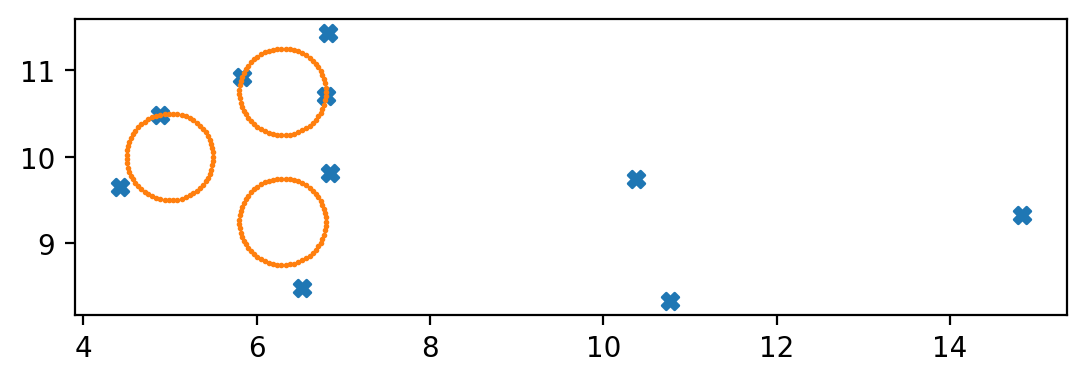

In [47]:
scatter_array(coords[extract_sensor_indices_pinball(coords[:, :2], np.array(centers), R, nsensors, dist_min=0.5, dist_edge=0.0)], marker="X")
scatter_array(pinball_coords,s=1)

In [48]:
XY = torch.from_numpy(np.repeat(np.expand_dims(coords, 0), repeats=ntrajectories, axis=0))

In [49]:
# Dataset su RAM

class SensorFieldDataset(Dataset):
    def __init__(self, hist, sensor_coords, targets):
        self.hist = hist
        self.sensor_coords = sensor_coords
        self.targets = targets
    def __len__(self):
        return self.hist.size(0)
    def __getitem__(self, idx):
        return (
            self.hist[idx],
            self.sensor_coords[idx],
            self.targets[idx]
        )

# # Load training dataset
# train_hist = torch.load('data/train_hist.pt').float().to(device)
# sensor_coords_exp = torch.load('data/sensor_coords_exp.pt').float().to(device)
# train_out = torch.load('data/train_out.pt').float().to(device)

# Generate training dataset
n_sensors_choices_per_trajectory = 5
# sensors_data_train = torch.zeros((n_sensors_choices_per_trajectory * ntrain, ntimes, nsensors))
train_hist = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, nsensors, lag)).to(device)
train_out = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, kvelocity + 1)).to(device)
sensor_coords_exp = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, nsensors, coord_dim)).to(device)
for i in range(n_sensors_choices_per_trajectory):
    sensors_idx_train = np.stack([
        # np.random.choice(nvelocity, nsensors, replace=False)
        # extract_sensor_indices(naca0012_coords, naca0012_airfoil_coords, nsensors, dist_min=1, idx_le=le_id_true, idx_te=te_id_true, chord=chord, dist_edge=0.5)
        extract_sensor_indices_pinball(coords, np.array(centers), R, nsensors, dist_min=0.5, dist_edge=0.0)

        for _ in range(ntrain)
    ], axis=0)    # (n_sensors_choices_per_trajectory * ntrain, nsensors)

    # sensors_idx_train = indices[idx_train]       # (ntrain,5)
    traj_idx_train    = np.arange(ntrain)[:, None, None]   # (ntrain,1,1)
    time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)
    # sensors_idx_train = sensors_idx_train[:, None, :]      # (ntrain,1,5)
    # sensors_data_train[i*ntrain : (i+1)*ntrain] = Vxtrain[traj_idx_train, time_idx, sensors_idx_train[:, None, :]] # → (ntrain,201,5)

    train_hist[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = Padding(Vxtrain[traj_idx_train, time_idx, sensors_idx_train[:, None, :]], lag).transpose(1,2) #.to(device) # (N_samples, nsensors, lag)
    train_out[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) #.to(device) # (N_samples, nvelocity)

    sensor_coords_exp[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = torch.from_numpy(np.repeat(XY.numpy()[idx_train][np.arange(ntrain)[:, None, None],
                      sensors_idx_train[:, :, None],
                      np.arange(coord_dim)[None, None, :]], repeats=ntimes, axis=0)).to(torch.float) #.to(device)
    sensor_coords_exp[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = torch.from_numpy(np.repeat(XY.numpy()[idx_train][np.arange(ntrain)[:, None, None],
                                                                                                                sensors_idx_train[:, :, None],
                                                                                                                np.arange(coord_dim)[None, None, :]],
                                                                                    repeats=ntimes, axis=0)).to(torch.float) #.to(device)
# field_coords_exp = torch.from_numpy(np.repeat(XY[idx_train], repeats=ntimes*n_sensors_choices_per_trajectory, axis=0)).to(torch.float) #.to(device)

# # Load valid dataset
# valid_hist = torch.load('data/valid_hist.pt').float().to(device)
# sensor_coords_exp_valid = torch.load('data/sensor_coords_exp_valid.pt').float().to(device)
# valid_out = torch.load('data/valid_out.pt').float().to(device)



In [50]:
# Generate valid dataset
valid_hist = torch.zeros((n_sensors_choices_per_trajectory * nvalid * ntimes, nsensors, lag)).to(device)
valid_out = torch.zeros((n_sensors_choices_per_trajectory * nvalid * ntimes, kvelocity + 1)).to(device)
sensor_coords_exp_valid = torch.zeros((n_sensors_choices_per_trajectory * nvalid * ntimes, nsensors, coord_dim)).to(device)
for i in range(n_sensors_choices_per_trajectory):
    sensors_idx_valid = np.stack([
        # np.random.choice(nvelocity, nsensors, replace=False)
        # extract_sensor_indices(naca0012_coords, naca0012_airfoil_coords, nsensors, dist_min=1, idx_le=le_id_true, idx_te=te_id_true, chord=chord, dist_edge=0.5)
        extract_sensor_indices_pinball(coords, np.array(centers), R, nsensors, dist_min=0.5, dist_edge=0.0)
        for _ in range(nvalid)
    ], axis=0)

    traj_idx_valid    = np.arange(nvalid)[:, None, None]   # (nvalid,1,1)
    time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)

    valid_hist[i*nvalid*ntimes : (i+1)*nvalid*ntimes] = Padding(Vxvalid[traj_idx_valid, time_idx, sensors_idx_valid[:, None, :]], lag).transpose(1,2) #.to(device) # (N_samples, nsensors, lag)
    valid_out[i*nvalid*ntimes : (i+1)*nvalid*ntimes] = Padding(torch.cat((Vxvalid_POD, Vyvalid_POD, MUvalid[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) #.to(device) # (N_samples, nvelocity)

    sensor_coords_exp_valid[i*nvalid*ntimes : (i+1)*nvalid*ntimes] = torch.from_numpy(np.repeat(XY.numpy()[idx_valid][np.arange(nvalid)[:, None, None],
                      sensors_idx_valid[:, :, None],
                      np.arange(coord_dim)[None, None, :]], repeats=ntimes, axis=0)).to(torch.float) #.to(device)


In [51]:
# scatter_array(naca0012_airfoil_coords)
# scatter_array(naca0012_coords[sensors_idx_train[7]])
# add_zoom()

In [52]:
# Instantiate datasets and loaders
train_dataset = SensorFieldDataset(train_hist, sensor_coords_exp, train_out)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
valid_dataset = SensorFieldDataset(valid_hist, sensor_coords_exp_valid, valid_out)
valid_loader = DataLoader(valid_dataset, batch_size=2048, shuffle=True)

In [53]:
# # Dataset su disco

# # # Salva i tensori sul disco in formato .pt
# # torch.save(train_hist, 'train_hist.pt')
# # torch.save(sensor_coords_exp, 'sensor_coords_exp.pt')
# # torch.save(train_out, 'train_out.pt')

# class TorchSensorFieldDataset(Dataset):
#     def __init__(self, hist_path, coords_path, out_path):
#         # Carica i tensori in CPU (non occupano GPU fino all'utilizzo)
#         self.hist = torch.load(hist_path, map_location='cpu')
#         self.coords = torch.load(coords_path, map_location='cpu')
#         self.out = torch.load(out_path, map_location='cpu')
#         assert len(self.hist) == len(self.coords) == len(self.out)

#     def __len__(self):
#         return self.hist.size(0)

#     def __getitem__(self, idx):
#         # Slicing diretto su PyTorch Tensor non genera warning
#         hist = self.hist[idx]
#         coords = self.coords[idx]
#         out = self.out[idx]
#         return hist, coords, out

# # Crea il dataset "Torch"
# train_dataset = TorchSensorFieldDataset(
#     hist_path='data/train_hist.pt',
#     coords_path='data/sensor_coords_exp.pt',
#     out_path='data/train_out.pt'
# )

# # DataLoader (usa num_workers=2 o 0 se necessario per il tuo sistema)
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=2048,
#     shuffle=True,
#     num_workers=2,    # regola in base alle risorse disponibili
#     pin_memory=True   # ottimizza trasferimento a GPU
# )

# valid_dataset = TorchSensorFieldDataset(
#     hist_path='data/valid_hist.pt',
#     coords_path='data/sensor_coords_exp_valid.pt',
#     out_path='data/valid_out.pt'
# )
# valid_loader = DataLoader(
#     valid_dataset,
#     batch_size=2048,
#     shuffle=True,
#     num_workers=2,    # regola in base alle risorse disponibili
#     pin_memory=True   # ottimizza trasferimento a GPU
# )


In [54]:
# Instantiate model (using the modified SHRED)
# latent_dim chosen as you prefer
latent_dim = 128
output_size = kvelocity + 1
model = SHREDagnosticAttention(coord_dim=coord_dim,
              latent_dim=latent_dim,
              output_size=output_size,
              hidden_size=64,
              lstm_layers=2,
              decoder_sizes=[350, 400, output_size],
              dropout=0.1,
              use_gnn=True)

import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
def fit_agnostic(model,
                 train_loader,
                 valid_loader,
                 epochs=100,
                 lr=1e-3,
                 loss_fun=torch.nn.MSELoss(),
                 patience=50,
                 factor=0.8,
                 plateau_patience=20):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=factor,
        patience=plateau_patience,
        # verbose=True
    )
    history = {'train_loss': [], 'valid_loss': [], 'epoch_time': []}

    best_model_wts = deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        running_train_loss = 0.0
        running_valid_loss = 0.0

        # tot_batches = train + valid
        tot_batches = len(train_loader) + len(valid_loader)
        pbar = tqdm(total=tot_batches,
                    desc=f"Epoch {epoch}/{epochs}",
                    unit="batch",
                    leave=False)

        # --- TRAIN ---
        model.train()
        for hist, coords, tgt in train_loader:
            optimizer.zero_grad()
            pred, _ = model(hist, coords)
            loss = loss_fun(pred, tgt)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * hist.size(0)
            pbar.set_postfix(stage='train', loss=f"{loss.item():.4f}")
            pbar.update(1)

        avg_train_loss = running_train_loss / len(train_loader.dataset)

        # --- VALID ---
        model.eval()
        with torch.no_grad():
            for hist, coords, tgt in valid_loader:
                pred, _ = model(hist, coords)
                loss_val = loss_fun(pred, tgt)

                running_valid_loss += loss_val.item() * hist.size(0)
                pbar.set_postfix(stage='valid', loss=f"{loss_val.item():.4f}")
                pbar.update(1)

        avg_valid_loss = running_valid_loss / len(valid_loader.dataset)

        pbar.close()
        epoch_time = time.time() - epoch_start

        scheduler.step(avg_valid_loss)

        # Early stopping
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Logging
        history['train_loss'].append(avg_train_loss)
        history['valid_loss'].append(avg_valid_loss)
        history['epoch_time'].append(epoch_time)
        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train: {avg_train_loss:.6f} | "
            f"Valid: {avg_valid_loss:.6f} | "
            f"lr: {scheduler.get_last_lr()[0]:.6f} | "
            f"Time: {epoch_time:.1f}s | "
            f"NoImprove: {epochs_no_improve}/{patience}"
        )

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping: valid loss non migliora da {patience} epoche.")
            final_epochs = epoch
            break

    model.load_state_dict(best_model_wts)
    return history


In [55]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)

model = model.to(device)

In [ ]:
# Run training
history = fit_agnostic(model, train_loader, valid_loader, epochs=500, lr=1e-3, patience=100, plateau_patience=20, factor=0.8)

In [57]:
final_epochs = 156

In [ ]:
# # Assumendo che `model` sia un'istanza di SHREDagnostic
torch.save(model.state_dict(), f"models/newinitsensors_sensdropout_gnn_{final_epochs}ep.pth")

In [ ]:
model.load_state_dict(torch.load( "models/newinitsensors_sensdropout_gnn_156ep.pth", weights_only=True, map_location=torch.device('cpu')))
model.eval()

In [ ]:
model.eval()

In [59]:
torch.cuda.empty_cache()

In [60]:
Vtest = torch.sqrt(Vxtest**2 + Vytest**2)

In [61]:
from matplotlib.colors import Normalize
from matplotlib import cm
import imageio
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.transforms import Bbox

def trajectories_with_sensors(yts, plot, sensors_coordinates_list,
                              cmap=None, titles=None, fontsize=None, figsize=None, vertical=False, axis=False, save=False, name='gif', plot_sensors = True, display_ = True):
    arrays = []
    # num_sensors = len(sensors_coordinates)

    vmin = min(np.abs(yts[i]).min() for i in range(len(yts)))
    vmax = max(np.abs(yts[i]).max() for i in range(len(yts)))
    norm = Normalize(vmin = vmin, vmax = vmax)

    if save:
        writer = imageio.get_writer(name.replace(".gif", "") + ".gif", mode='I', duration=0.1)

    for i in range(yts[0].shape[0]):
        fig, axs = plt.subplots(len(yts) if vertical else 1, 1 if vertical else len(yts), figsize=figsize)
        axs = np.atleast_1d(axs)

        for j, ax in enumerate(axs):
            plt.sca(ax)
            plot(yts[j][i], norm=norm, cmap = cmap)
            # if (j == len(yts) - 2) & plot_sensors:
            #     for k in range(num_sensors):
            #         ax.plot(sensors_coordinates[k, 0], sensors_coordinates[k, 1], 'o', mfc='magenta', mec='black', ms=8, mew=1.5)
            sensors_coordinates = sensors_coordinates_list[j]
            if not (sensors_coordinates == []):
                num_sensors = len(sensors_coordinates)
                if titles[j] == "SHRED prediction (sensor walk)":
                    for i in range(num_sensors):
                        traj = np.array([step[i] for step in sensors_history])
                        plt.gca().plot(traj[:, 0], traj[:, 1], color='magenta', label='_nolegend_', linewidth = 1)
                        plt.gca().scatter(traj[0, 0], traj[0, 1], color='magenta', edgecolors='k', marker='o', s = 10, label='_nolegend_')
                        plt.gca().scatter(traj[-1, 0], traj[-1, 1], color='magenta', edgecolors='k', marker='X', s=100, label='_nolegend_')
                        # plt.gca().plot(traj[0, 0], traj[0, 1], mfc='magenta', mec='black', marker='o', ms=8, mew=1.5, alpha = 0.5, label='_nolegend_')
                        # plt.gca().scatter(traj[-1, 0], traj[-1, 1], mfc='magenta', mec='black', marker='X', ms=8, mew=1.5, alpha = 1, label='_nolegend_')
                    plt.gca().scatter([], [], color='magenta', edgecolors='k', marker='o', label='Start')
                    plt.gca().scatter([], [], color='magenta', edgecolors='k', marker='X', s=100, label='End')
                    plt.gca().legend(loc = "upper right")
                else:
                    for k in range(num_sensors):
                        # ax.plot(sensors_coordinates[k, 0], sensors_coordinates[k, 1], 'o', mfc='magenta', mec='black', marker='X', ms=8, mew=1.5)
                        ax.scatter(sensors_coordinates[k, 0], sensors_coordinates[k, 1], color='magenta', edgecolors='k', marker='X', s=100, label='_nolegend_')
            if titles:
                ax.set_title(titles[j], fontsize=fontsize)
            if not axis:
                ax.axis('off')

        plt.colorbar(
              cm.ScalarMappable(cmap=cmap, norm=norm),
              # ax=axs[0],
              cax = fig.add_axes([-0.01, 0.35, 0.01, 0.3]),
              location="left",
              orientation="vertical",
              pad=0.02,           # più piccolo = meno distanza
              fraction=0.04,      # più piccolo = colorbar più sottile
              aspect=40           # opzionale, controlla il rapporto larghezza/altezza
            )

        fig.tight_layout()
        if display_:
            display(fig)
        # costrusci fig e ottieni `frame = np.array(fig.canvas.renderer.buffer_rgba())`
        if save:
            writer.append_data((np.array(fig.canvas.renderer.buffer_rgba())))
        plt.close(fig)
        clc(wait=True)

    if save:
        writer.close()
    # if save:
    #     imageio.mimsave(name.replace(".gif", "") + ".gif", arrays)

In [64]:
from sklearn.utils.extmath import randomized_svd
import scipy

whichtrajectory_qrpiv = 0
print(f"Aoa={MUtest.numpy()[whichtrajectory_qrpiv, 0, 0]:.1f}°")

Ux_traj, Sx_traj, Wx_traj = randomized_svd(Vxtest[whichtrajectory_qrpiv].numpy(), n_components = kvelocity//2)
r = kvelocity//2
n_sensors = kvelocity//2
if (nsensors <= r):
    Q, R, gamma = scipy.linalg.qr(Wx_traj, pivoting = True)
else:
    Q, R, gamma = scipy.linalg.qr(Wx_traj.transpose() @ Wx, pivoting = True)
# sensors_coords_test_qrpiv = XY[idx_test][whichtrajectory][gamma[:nsensors]].unsqueeze(0) # (1, nsensors_test, 2)

Aoa=-3.3°


In [65]:
# Vplot = np.mean(Vtest.numpy()[whichtrajectory_qrpiv], axis = 0)
time_idx = 20
Vplot = Vtest.numpy()[whichtrajectory_qrpiv, time_idx]

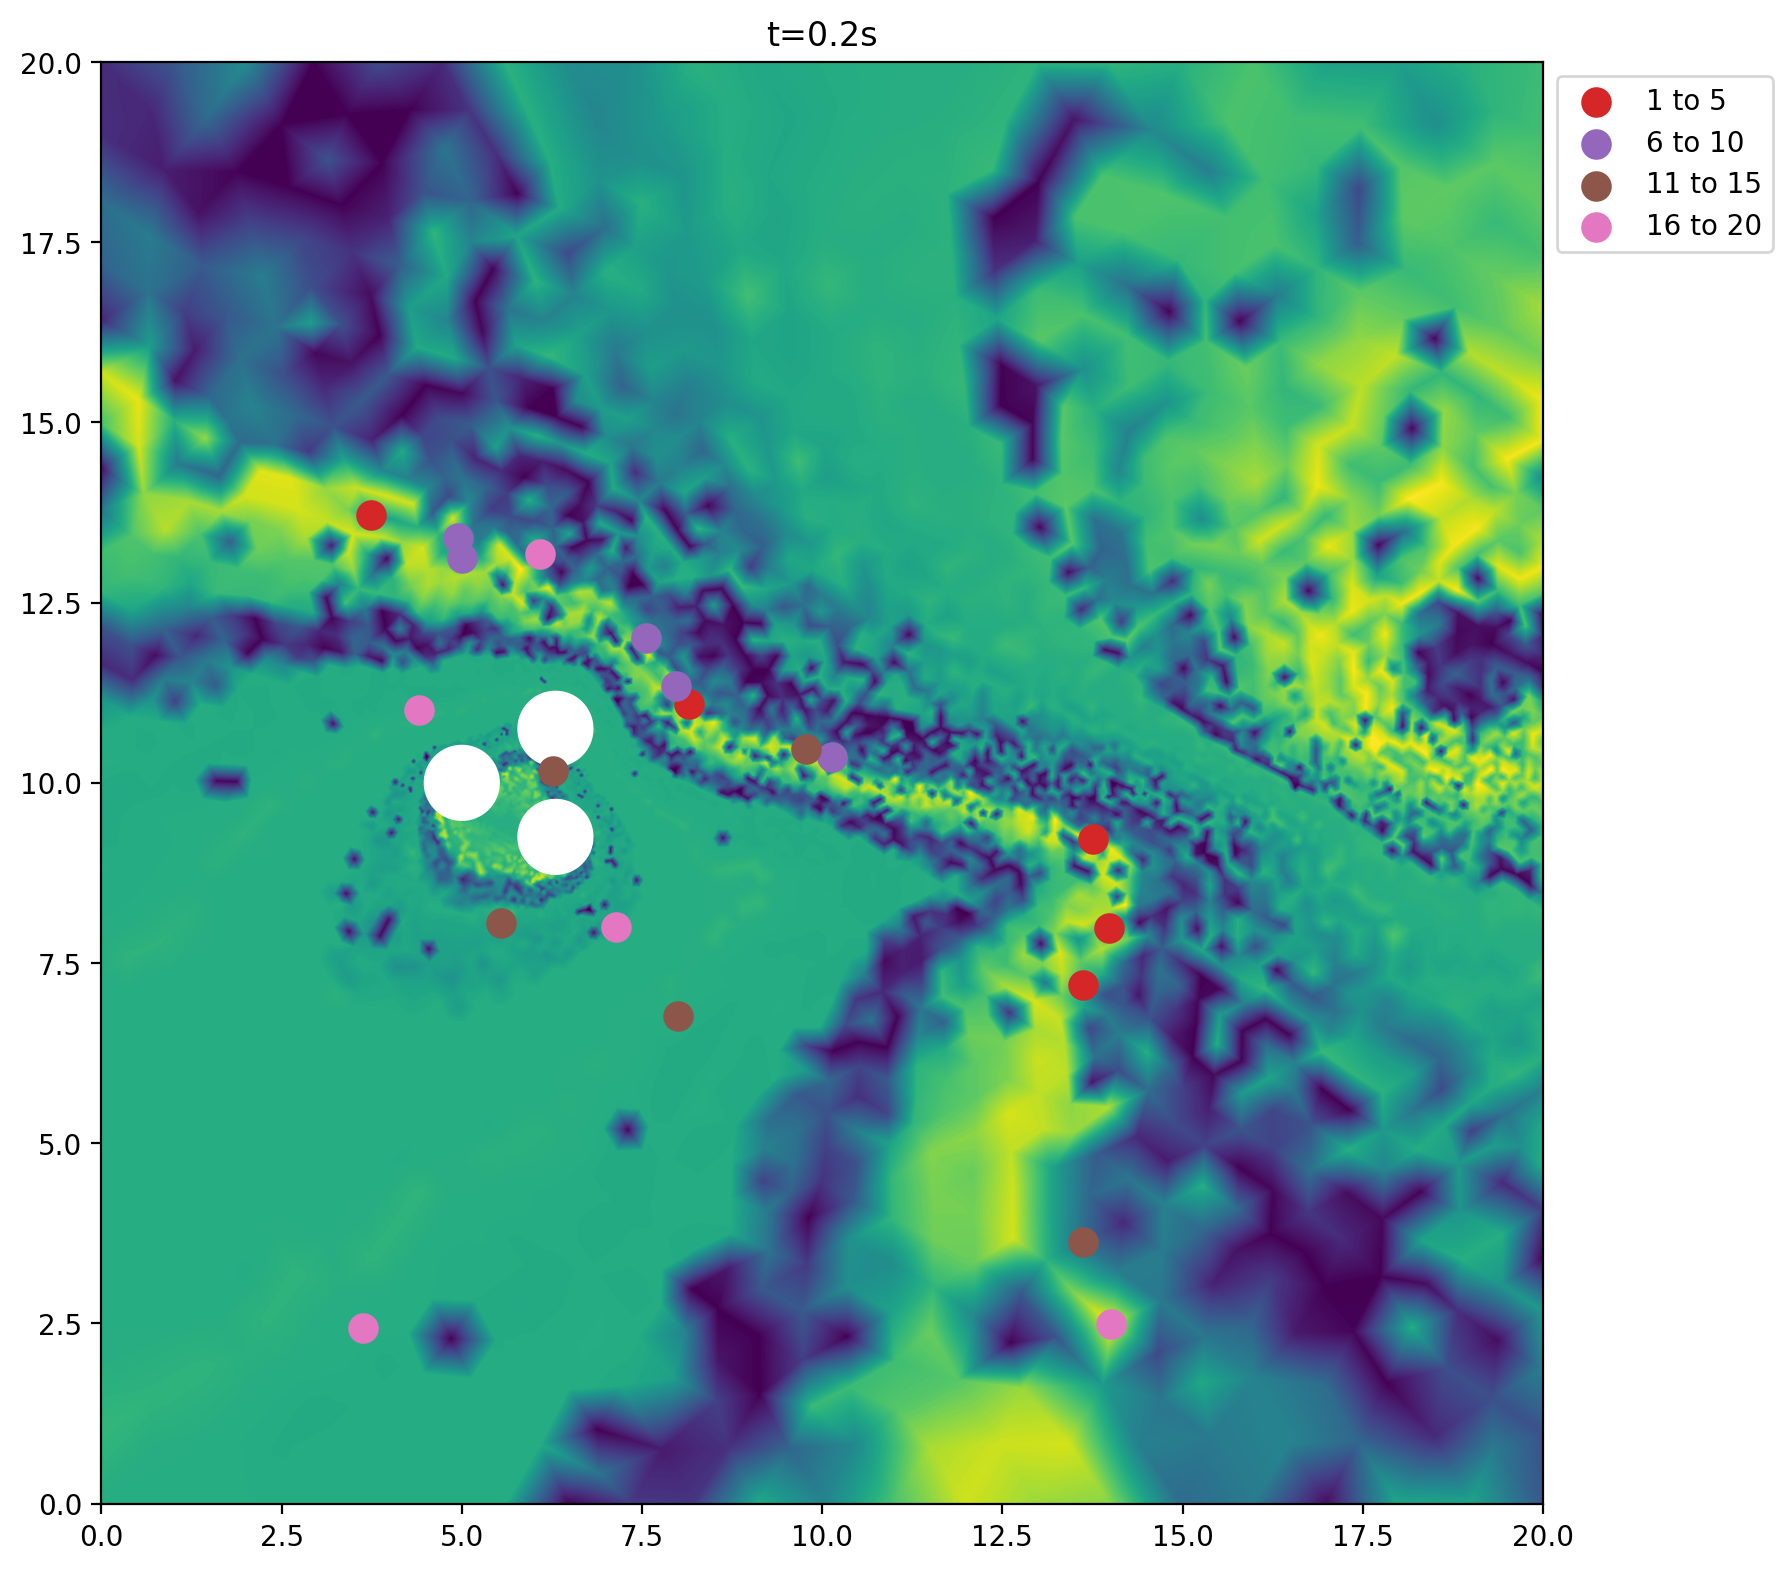

In [67]:
params_geo = MUtest[whichtrajectory_qrpiv, 0, 2:]

triang = tri.Triangulation(x[:, 0], y[:, 0])
def plot_v(v, triang = triang, norm=None, cmap="viridis", levels=200):
    plt.tricontourf(triang, v, cmap = cmap, levels = 200)
    plt.gca().set_aspect("equal")
    add_zoom(zoom = 1.3)
    for cyl in cyl_coords:
        plt.gca().fill(cyl[:, 0], cyl[:, 1],
                              facecolor='white',
                              edgecolor='white',
                              linewidth=1.5)
    # add_zoom(zoom = 1.1)
plot_v(Vplot)

# scatter_array(naca0012_airfoil_coords, label="_nolegend_")
subset = 5
nsensors_to_plot = 20
for i in range(nsensors_to_plot // subset + int(nsensors_to_plot % subset > 0)):
    scatter_array(XY[idx_test][whichtrajectory_qrpiv][gamma[subset*i:subset*(i+1)]], s=100, label=f"{subset*i + 1} to {subset*(i+1)}")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.title(f"t={(time_idx*save_to_np_every_steps)/timesteps*T:.1f}s")
add_zoom()

In [ ]:
# COLORMAP

# import seaborn as sns
# from matplotlib import colors
# ice = sns.color_palette("icefire", as_cmap=True).colors
# col = [ice[i] for i in np.concatenate((np.arange(128,0,-10), np.arange(254,128,-9)))]
# col.insert(0, "black")
# cmap = colors.LinearSegmentedColormap.from_list("", col)

cmap = "jet"

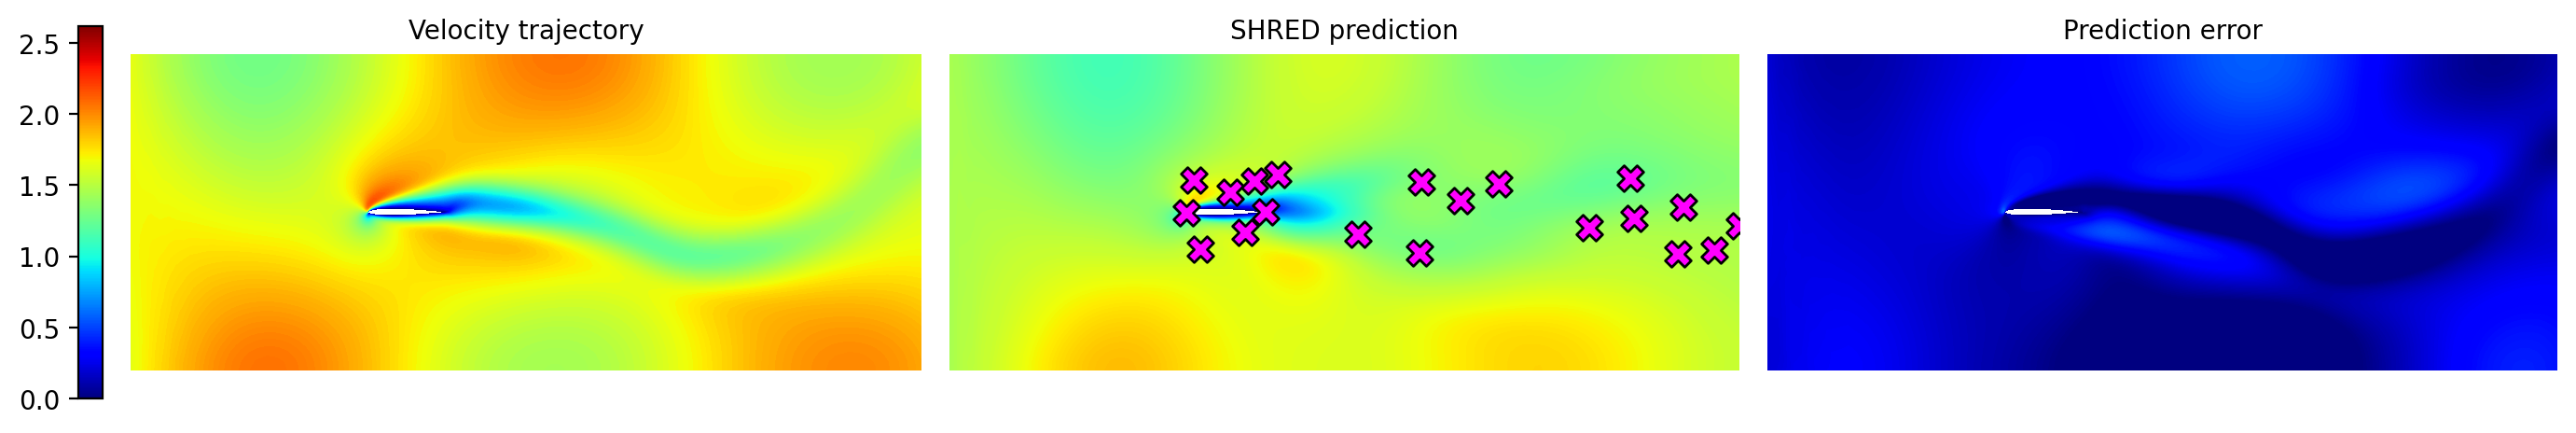

In [ ]:
whichtimes = np.arange(0, 200, 5)
# whichtrajectory = np.random.choice(ntest)
whichtrajectory = 8
mult = 2

nsensors_test = int(nsensors * mult)

# sensors_idx_test = np.random.choice(nvelocity, nsensors_test, replace=False)
sensors_idx_test = extract_sensor_indices(naca0012_coords, naca0012_airfoil_coords, nsensors_test, dist_min=0.33, idx_le=le_id_true, idx_te=te_id_true, chord=chord, dist_edge=0.5)
# sensors_idx_test = sensors_idx_test[None, :]      # (1, nsensors_test)

# sensors_data_test = Vxtest[traj_idx_test, time_idx, sensors_idx_test].unsqueeze(0) (1, ntimes, nsensors_test)
sensors_data_test = Vxtest[whichtrajectory, :, sensors_idx_test].unsqueeze(0) # (1, ntimes, nsensors_test)
test_hist = Padding(sensors_data_test, lag).transpose(1,2) # (ntimes, lag, nsensors_test)

sensors_coords_test = XY[idx_test][whichtrajectory][sensors_idx_test].unsqueeze(0) # (1, nsensors_test, 2)

model.eval();
with torch.no_grad():
    Vtest_POD = model(test_hist.to(device).contiguous(), sensors_coords_test.repeat(ntimes, 1, 1).to(device))[0][:, :-1]
Vtest_hat = torch.sqrt((torch.from_numpy(scalerVx.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,:kvelocity//2])).float() @ Wx).view(1, ntimes, nvelocity)**2 \
                      + \
                      (torch.from_numpy(scalerVy.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,kvelocity//2:])).float() @ Wy).view(1, ntimes, nvelocity)**2)

# plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat.numpy()[0, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[0, whichtimes]]
plotlist = [
        Vtest[whichtrajectory, whichtimes],
        Vtest_hat.numpy()[0, whichtimes],
        # Vtest_hat_qrpiv.numpy()[0, whichtimes],
        Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[0, whichtimes],
        ]
titles = (
          "Velocity trajectory",
          "SHRED prediction",
          # "SHRED prediction (qr-pivoted sensors)",
          "Prediction error",
          )
sensors_coordinates_list  = [
                            [],
                            sensors_coords_test[0],
                            # sensors_coords_test_qrpiv[0],
                            [],
                            ]

params_geo = MUtest[whichtrajectory, 0, 2:]
# redefine plot_v on new triang
triang = tri.Triangulation(x, y)
def plot_v(v, triang = triang, norm=None, cmap="viridis", levels=200):
    plt.tricontourf(triang, v, cmap = cmap, levels = 200)
    plt.gca().set_aspect("equal")
    add_zoom(zoom = 1.3)
    for cyl in cyl_coords:
        plt.gca().fill(cyl[:, 0], cyl[:, 1],
                              facecolor='white',
                              edgecolor='white',
                              linewidth=1.5)

trajectories_with_sensors(plotlist, plot_v, sensors_coordinates_list,
                      titles = titles,
                      figsize = (10, 5), vertical = False,
                      # save = True, name = f"gifs/traj{whichtrajectory}_sens{nsensors_test}",
                      cmap = cmap,
                      # plot_sensors = False,
                      )

In [ ]:
import gc
whichtimes = np.arange(0, 200, 5)

# for whichtrajectory in range(ntest):
if False:
    for mult in [10]:
        for whichtrajectory in range(ntest):
            # mult = 10
            print(f"traj {whichtrajectory}, mult {mult}")
            nsensors_test = int(nsensors * mult)

            sensors_idx_test = np.random.choice(nvelocity, nsensors_test, replace=False)
            # sensors_idx_test = sensors_idx_test[None, :]      # (1, nsensors_test)

            # sensors_data_test = Vxtest[traj_idx_test, time_idx, sensors_idx_test].unsqueeze(0) (1, ntimes, nsensors_test)
            sensors_data_test = Vxtest[whichtrajectory, :, sensors_idx_test].unsqueeze(0) # (1, ntimes, nsensors_test)
            test_hist = Padding(sensors_data_test, lag).transpose(1,2) # (ntimes, lag, nsensors_test)

            sensors_coords_test = XY[idx_test][whichtrajectory][sensors_idx_test].unsqueeze(0) # (1, nsensors_test, 2)

            model.eval();
            with torch.no_grad():
                Vtest_POD = model(test_hist.to(device).contiguous(), sensors_coords_test.repeat(ntimes, 1, 1).to(device))[:, :-1]
            Vtest_hat = torch.sqrt((torch.from_numpy(scalerVx.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,:kvelocity//2])).float() @ Wx).view(1, ntimes, nvelocity)**2 \
                                  + \
                                  (torch.from_numpy(scalerVy.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,kvelocity//2:])).float() @ Wy).view(1, ntimes, nvelocity)**2)

            # plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat.numpy()[0, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[0, whichtimes]]
            plotlist = [
                    Vtest[whichtrajectory, whichtimes],
                    Vtest_hat.numpy()[0, whichtimes],
                    # Vtest_hat_qrpiv.numpy()[0, whichtimes],
                    Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[0, whichtimes],
                    ]
            titles = (
                      "Velocity trajectory",
                      "SHRED prediction",
                      # "SHRED prediction (qr-pivoted sensors)",
                      "Prediction error",
                      )
            sensors_coordinates_list  = [
                                        [],
                                        sensors_coords_test[0],
                                        # sensors_coords_test_qrpiv[0],
                                        [],
                                        ]

            params_geo = MUtest[whichtrajectory, 0, 2:]
            # redefine plot_v on new triang
            _, triang = update_coords_and_triang(params_geo)
            def plot_v(v, triang = triang, norm = None, cmap = cmap):
                if not norm == None:
                    plt.tricontourf(triang, v, cmap = cmap, norm = norm, levels = 200)
                else:
                    plt.tricontourf(triang, v, cmap = cmap, levels = 200)
                plt.gca().set_aspect("equal")
                add_zoom(zoom = 1.1)

            trajectories_with_sensors(plotlist, plot_v, sensors_coordinates_list,
                                  titles = titles,
                                  figsize = (10, 5), vertical = False, save = True, name = f"gifs/traj{whichtrajectory}_sens{nsensors_test}",
                                  display_ = False,
                                  cmap = cmap,
                                  # plot_sensors = False,
                                  )

            plt.close('all')
            gc.collect()

            # del Vtest
            del sensors_idx_test
            del sensors_data_test
            del test_hist
            del sensors_coords_test
            del Vtest_POD
            del Vtest_hat
            del plotlist

In [ ]:
del Vtest
del sensors_idx_test
del sensors_data_test
del test_hist
del sensors_coords_test
del Vtest_POD
del Vtest_hat
del plotlist


### plot qrpivoted region

In [ ]:
from shapely.geometry import Point, Polygon, box
from shapely.ops import unary_union
import numpy as np
import matplotlib.pyplot as plt


def generate_confidence_region(points, radius, boundary_pts, L, H, buffer_method='union', make_convex=False):
    """
    Genera una regione di confidenza attorno a un insieme di punti, ritagliata al dominio,
    scolpita dal contorno dell'airfoil e opzionalmente resa convessa per ogni componente.

    Parametri
    --------
    points : array-like di shape (n_points, 2)
        Coordinate (x,y) dei punti di input.
    radius : float
        Raggio dei dischi da considerare attorno a ogni punto.
    boundary_pts : array-like di shape (n_airfoil, 2)
        Coordinate del contorno interno dell'airfoil (poligono chiuso).
    L, H : float
        Dimensioni del dominio rettangolare [0, L] x [0, H].
    buffer_method : str, opzionale
        Metodo per aggregare:
          - 'union': unisce cerchi di raggio `radius` attorno a ogni punto;
          - 'convex_hull': usa l'inviluppo convesso dei punti e lo dilata di `radius`.
    make_convex : bool, opzionale
        Se True, trasforma ciascuna componente della regione in un poligono convesso.

    Ritorna
    -------
    region : shapely.geometry.Polygon o MultiPolygon
        Poligono che rappresenta la regione di confidenza, ritagliato al dominio,
        senza interno airfoil e con componenti eventualmente rese convesse.
    """
    pts = np.asarray(points)

    # 1) Genera buffer union o hull
    if buffer_method == 'union':
        disks = [Point(x, y).buffer(radius) for x, y in pts]
        region = unary_union(disks)
    elif buffer_method == 'convex_hull':
        from shapely.geometry import MultiPoint
        base_hull = MultiPoint(pts).convex_hull
        region = base_hull.buffer(radius)
    else:
        raise ValueError("buffer_method non riconosciuto")

    # 2) Opzionale: rendi convesso prima di ritagliare e sottrarre
    if make_convex:
        if region.geom_type == 'Polygon':
            region = region.convex_hull
        else:
            convex_parts = [poly.convex_hull for poly in region.geoms]
            region = unary_union(convex_parts)

    # 3) Ritaglia al dominio rettangolare
    domain = box(0, 0, L, H)
    region = region.intersection(domain)

    # 4) Sottrai interno airfoil
    airfoil_poly = Polygon(boundary_pts)
    region = region.difference(airfoil_poly)

    return region
def sample_points_in_region(region, n_samples, random_state=None):
    """
    Estrae punti casuali uniformi all'interno di un Polygon o MultiPolygon.

    Parametri
    --------
    region : Polygon o MultiPolygon
        Regione nella quale campionare.
    n_samples : int
        Numero di punti casuali da estrarre.
    random_state : int o None
        Seed per replicabilità.

    Ritorna
    -------
    samples : ndarray shape (n_samples, 2)
        Coordinate dei punti estratti.
    """
    minx, miny, maxx, maxy = region.bounds
    rng = np.random.default_rng(random_state)
    samples = []
    while len(samples) < n_samples:
        x = rng.uniform(minx, maxx)
        y = rng.uniform(miny, maxy)
        pt = Point(x, y)
        if region.contains(pt):
            samples.append((x, y))
    return np.array(samples)


def plot_region(region, points=None, samples=None, figsize=(6,6)):
    """
    Visualizza la regione di confidenza, i punti originali e i campioni.

    Parametri
    --------
    region : Polygon o MultiPolygon
    points : array-like di shape (n_points, 2), opzionale
        Punti originali da mostrare come scatter.
    samples : array-like di shape (m, 2), opzionale
        Punti campionati da evidenziare.
    figsize : tuple, opzionale
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Disegna regione
    if isinstance(region, Polygon):
        polys = [region]
    else:
        polys = list(region.geoms)
    for poly in polys:
        x,y = poly.exterior.xy
        ax.fill(x, y, alpha=0.3, fc='blue', edgecolor='black')
        for interior in poly.interiors:
            ix, iy = interior.xy
            ax.fill(ix, iy, color='white')  # o color=ax.get_facecolor()

    # Punti originali
    if points is not None:
        pts = np.asarray(points)
        ax.scatter(pts[:,0], pts[:,1], c='blue', s=10, label='Originali')

    # Punti campionati
    if samples is not None:
        s = np.asarray(samples)
        ax.scatter(s[:,0], s[:,1], c='red', s=10, label='Campionati')

    ax.set_aspect('equal')
    ax.legend()
    ax.set_title('Regione di confidenza e punti')
    add_zoom()
    # plt.show()



In [ ]:
r = kvelocity//2
n_sensors = kvelocity//2
if (nsensors <= r):
    Q, R, gamma = scipy.linalg.qr(Wx, pivoting = True)
else:
    Q, R, gamma = scipy.linalg.qr(Wx.transpose() @ Wx, pivoting = True)


In [ ]:
nsensors_qrpiv = 40
region = generate_confidence_region(XY[idx_test][whichtrajectory_qrpiv][gamma[:nsensors_qrpiv]],
                                    radius=0.5,
                                    boundary_pts=np.array(naca0012_airfoil_coords.tolist() + [naca0012_airfoil_coords[0].tolist()]),
                                    L=L, H=H, buffer_method='union', make_convex=False)
sample_pts = sample_points_in_region(region, n_samples=10, random_state=None)
plot_region(region, points=XY[idx_test][whichtrajectory_qrpiv][gamma[:nsensors_qrpiv]], samples=sample_pts, figsize=(6,6))
# scatter_array(naca0012_airfoil_coords)

### Sensor walk

In [ ]:
model.load_state_dict(torch.load( "models/newinitsensors_sensdropout_281ep.pth", weights_only=True, map_location=torch.device('cpu')))
model.eval();

In [ ]:
# Le posizioni dei sensori sono variabili trainabili
d = coord_dim
# sensors_coords = torch.rand(nsensors, d, device=device, requires_grad=True)
# sensors_coords.data.mul_(torch.tensor([L, H], device=device, dtype=torch.float32))
init_sensors_coords = naca0012_coords[extract_sensor_indices(naca0012_coords, naca0012_airfoil_coords, nsensors, dist_min=1, idx_le=le_id_true, idx_te=te_id_true, chord=chord, dist_edge=0.5), :2]
sensors_coords = torch.as_tensor(init_sensors_coords, device=device, dtype=torch.float32)
sensors_coords.requires_grad=True

In [ ]:
# Definizione della funzione di Fourier Positional Encoding
def fourier_encode(x, B):
    """
    Applica il positional encoding Fourier alle coordinate.

    Parametri:
      - x: tensor di shape (n, d) (ad esempio, coordinate spaziali)
      - B: tensor di shape (d, D) contenente le frequenze.

    Restituisce:
      - encoding: tensor di shape (n, 2*D) ottenuto concatenando sin(xB) e cos(xB).
    """
    # Proiezione: x @ B produce un tensore di shape (n, D)
    x_proj = 2 * torch.pi * x @ B
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# Setup dei parametri e degli input
D = 16  # dimensione scelta per la proiezione (puoi variare questo parametro)
B = torch.randn(d, D).to(device)


In [ ]:
class SensorDataInterpolator(torch.nn.Module):
    def __init__(self, B, device = device):
        """
        XY: torch.Tensor di shape (ntraj, nvelocity, 2) -> coordinate dei nodi per traiettoria
        Vxtrain: torch.Tensor di shape (ntraj, ntimes, nvelocity) -> valori sui nodi (statici nel tempo)
        B: torch.Tensor di shape (2, D) -> matrice di frequenze per il Fourier encoding
        """
        super().__init__()
        self.B = B
        self.device = device

    def forward(self, sensors_coords, Vxtrain, node_encodings):
        """
        sensors_coords: torch.Tensor di shape (nsensors, 2  D) (trainable)

        Restituisce:
           sensor_data: tensor di shape (ntraj, ntimes, nsensors) ottenuto come interpolazione differenziabile
           dei valori Vxtrain nei nuovi punti dati dai sensors_coords_encoded.
        """

        ntraj, nvelocity, ntimes = Vxtrain.shape
        # print(Vxtrain.shape)

        nsensors = sensors_coords.shape[0]
        # Calcola l'encoding dei sensori
        sensor_encodings = fourier_encode(sensors_coords, self.B).to(self.device)  # shape: (nsensors, 2*D)
        # print(sensor_encodings.shape)
        # node_encodings: (ntraj, nvelocity, 2*D); vogliamo il prodotto scalare tra
        # ogni sensore ed ogni nodo per ogni traiettoria.
        # Risulta una similarità di shape: (ntraj, nsensors, nvelocity)

        # nsensors = sensor_encodings.shape[0]

        sensor_encodings_expanded = sensor_encodings.unsqueeze(0)  # (1, nsensors, 2*D)
        # print(sensor_encodings_expanded.shape)
        similarity = torch.matmul(sensor_encodings_expanded, node_encodings.transpose(1,2)).to(self.device)
        # print(similarity.shape)

        # Softmax lungo l'asse dei nodi per ottenere i pesi
        weights = F.softmax(similarity, dim=2).to(self.device)  # shape: (ntraj, nsensors, nvelocity)
        # print(weights.shape)
        # Per eseguire la somma pesata sui valori:
        # Vxtrain: (ntraj, ntimes, nvelocity)
        # Per la moltiplicazione batch, bisogna trasporre i pesi: (ntraj, nvelocity, nsensors)
        weights_t = weights.transpose(1,2)  # (ntraj, nvelocity, nsensors)
        # print(weights_t.shape)
        # print(Vxtrain.shape)

        sensor_vals = torch.matmul(Vxtrain, weights_t).to(self.device)

        return sensor_vals

In [ ]:
lag = 50
# optim_cls=torch.optim.Adam
lr_shred=1e-3
lr_sensors=0.1
batch_size = ntimes
epochs = 100
print_every_epochs = 5
update_sensors_every_steps = 20
scatter_sensors_every_steps = epochs

loss_fun = mse
loss_output = mre
formatter = num2p

train_error_list = []

In [ ]:
whichtrajectory = 11 # np.random.choice(ntest)

# Preinizializza l'ottimizzatore con i parametri del modello e anche sensors_coords
# Definisci due ottimizzatori:
optimizer_model = torch.optim.Adam(model.parameters(), lr=lr_shred)           # per il modello SHRED
optimizer_sensors = torch.optim.Adam([sensors_coords], lr=lr_sensors)         # per le coordinate dei sensori

node_encodings = fourier_encode(XY[whichtrajectory].unsqueeze(0).view(-1, XY.shape[-1]).to(device), B.to(device)).view(1, nvelocity, -1)
data_out = Padding(torch.cat((Vxtest_POD[whichtrajectory].unsqueeze(0),
                                    Vytest_POD[whichtrajectory].unsqueeze(0),
                                    MUtest[whichtrajectory,:,0].unsqueeze(0).unsqueeze(2)), 2), 1).squeeze(1).to(device)
sensor_interpolator = SensorDataInterpolator(B.to(device)).to(device)  # o device appropriato
sensors_data = sensor_interpolator(sensors_coords, Vxtest[whichtrajectory].unsqueeze(0).to(device), node_encodings.to(device))  # shape (ntraj, ntimes, nsensors)
train_dataset = TimeSeriesDataset(Padding(sensors_data, lag).to(device), data_out)

out_data_loader = DataLoader(data_out, shuffle=False, batch_size=batch_size)
sensors_history = [sensors_coords.detach().cpu().numpy()]

In [ ]:
# Assumiamo:
# - model: SHREDagnostic pretrained e messo in eval
# - sensor_interpolator: operatore che genera sensor_data
# - Padding, TimeSeriesDataset definiti
# - Vxtest, Vytest, MUtest, XY, Vxtest_POD, Vytest_POD, MUtest disponibili
# - mse, mre, num2p definiti
# - device, L, H, coord_dim, nsensors, lag, batch_size

# 1. Funzione per valutare una configurazione di sensori senza aggiornare i pesi del modello

def evaluate_coords(sensors_coords, whichtrajectory, batch_size):
    """
    Restituisce la loss di validazione (mse) per una data configurazione sensors_coords.
    sensors_coords: Tensor(nsensors, 2)
    """
    model.eval()
    with torch.no_grad():
        # genera dati sensori e dataset
        node_enc = fourier_encode(
            XY[whichtrajectory].unsqueeze(0).view(-1, XY.shape[-1]).to(device), B
        ).view(1, nvelocity, -1)
        sensor_data = sensor_interpolator(
            sensors_coords.to(device),
            Vxtest[whichtrajectory].unsqueeze(0).to(device),
            node_enc
        )
        in_data = Padding(sensor_data, lag).transpose(1,2).contiguous().to(device)
        coords_exp = sensors_coords.unsqueeze(0).expand(batch_size, -1, -1).contiguous().to(device)
        outputs = model(in_data, coords_exp)
        # assumiamo out_batch disponibile o usiamo data_out directly
        out_batch = data_out.to(device)
        loss_val = mse(outputs, out_batch)
    return loss_val.item()

# 2. Multi-start + selezione

def multi_start_select(K=20, M=5, whichtrajectory=0):
    """
    Campiona K configurazioni casuali, valuta e ritorna le top-M
    """
    all_coords = []
    losses = []
    for i in range(K):
        # campiona uniformemente su [0,L]x[0,H]
        coords = torch.rand(nsensors, coord_dim, device=device)
        coords.data.mul_(torch.tensor([L, H], device=device, dtype=torch.float32))
        loss_i = evaluate_coords(coords, whichtrajectory, batch_size)
        all_coords.append(coords)
        losses.append(loss_i)
        print(f"trial n° {i+1}; loss: {loss_i:2f}")
    losses = torch.tensor(losses)
    topk = torch.topk(-losses, M)  # massimi negativi = minimi
    best_coords = [all_coords[i] for i in topk.indices]
    return best_coords, losses[topk.indices]

# 3. Rifinitura locale con gradient descent

def refine_coords(init_coords, lr=1e-1, steps=100, whichtrajectory=0):
    """
    Data una configurazione iniziale, aggiorna sensors_coords con Adam per 'steps' iterazioni,
    mantenendo il modello fisso (o opzionalmente fine-tuning congiunto)
    """
    coords = init_coords.clone().detach().to(device)
    coords.requires_grad = True
    optimizer = torch.optim.Adam([coords], lr=lr)
    for _ in range(steps):
        model.eval()
        node_enc = fourier_encode(
            XY[whichtrajectory].unsqueeze(0).view(-1, XY.shape[-1]).to(device), B
        ).view(1, nvelocity, -1)
        sensor_data = sensor_interpolator(
            coords, Vxtest[whichtrajectory].unsqueeze(0).to(device), node_enc
        )
        in_batch = Padding(sensor_data, lag).transpose(1,2).contiguous()
        coords_exp = coords.expand(batch_size, -1, -1).contiguous()
        outputs = model(in_batch, coords_exp)
        loss = mse(outputs, data_out.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # riflettere i sensori entro domenio
        coords.data = reflect_with_grad_flip(coords.data, L, H)
    final_loss = evaluate_coords(coords.detach(), whichtrajectory, batch_size)
    return coords.detach(), final_loss

# 4. Main routine


In [ ]:
# # Parametri multi-start e refine
# K = 30   # numero di partenza random
# M = 5    # seleziona top M
# steps_refine = 50
# lr_refine = 0.05

# # 4.1 Multi-start + selezione
# best_inits, init_losses = multi_start_select(K=K, M=M, whichtrajectory=whichtrajectory)
# print("Initial top losses:", init_losses)

# # 4.2 Rifinitura su ognuna
# refined = []
# refined_losses = []
# for init in best_inits:
#     coords_ref, loss_ref = refine_coords(init, lr=lr_refine, steps=steps_refine, whichtrajectory=whichtrajectory)
#     refined.append(coords_ref)
#     refined_losses.append(loss_ref)
# refined_losses = torch.tensor(refined_losses)
# best_idx = torch.argmin(refined_losses)

# best_coords = refined[best_idx]
# print(f"Best refined loss: {refined_losses[best_idx]}")

# # Ora best_coords è la migliore configurazione trovata
# sensors_coords = best_coords.clone().detach().requires_grad_(True)
# # Prosegui eventualmente col training congiunto su modello + sensori...

In [ ]:
# !pip install scikit-optimize
# from skopt import gp_minimize
# # 1) BO: valutazioni iniziali
# def objective(flat_coords):
#     # converto in NumPy array e poi reshape
#     coords_np = np.array(flat_coords, dtype=np.float32).reshape(nsensors, d)
#     coords = torch.from_numpy(coords_np).to(device)

#     with torch.no_grad():
#         sensor_data = sensor_interpolator(coords, Vxtest[whichtrajectory].unsqueeze(0), node_encodings)
#         in_batch = Padding(sensor_data, lag).transpose(1,2).contiguous()
#         outputs = model(in_batch.to(device), coords.unsqueeze(0).expand(batch_size, -1, -1).contiguous())
#         loss = mse(outputs, data_out)
#     return loss.item()

# # Limiti per BO: [0,L] e [0,H] per ogni dimensione
# bounds = [(0, L), (0, H)] * nsensors

# res = gp_minimize(objective, bounds, n_calls=30, random_state=42)

# # 2) Warm-start del gradiente
# best_coords = torch.tensor(res.x, device=device).view(nsensors, d)
# sensors_coords.data.copy_(best_coords)
# # 2) Crei un nuovo leaf da cui far partire il gradiente
# sensors_coords = best_coords.float().clone().detach().requires_grad_(True)

# # 3) Ricostruisci l’ottimizzatore sui nuovi leaf
# optimizer_sensors = torch.optim.Adam([sensors_coords], lr=lr_sensors)

In [ ]:
sensors_coordinates_list = [sensors_coords.detach().cpu().numpy()]

In [ ]:
for epoch in range(epochs):
    # print(f"epoch {epoch}")
    for batch_idx, out_batch in enumerate(out_data_loader):
        model.train()
        # sensors_coords = torch.rand(nsensors, d, device=device, requires_grad=False)
        # sensors_coords.data.mul_(torch.tensor([L, H], device=device, dtype=torch.float32))
        sensor_data = sensor_interpolator(
            sensors_coords.to(device),
            Vxtest[whichtrajectory].unsqueeze(0).to(device),
            node_encodings.to(device),
        )

        in_batch = Padding(sensor_data, lag).transpose(1,2).contiguous().to(device)
        sensors_coords_expanded = sensors_coords.unsqueeze(0).expand(batch_size, -1, -1).contiguous()

        # Procedi con il resto del forward e backward
        # optimizer_model.zero_grad()
        optimizer_sensors.zero_grad()
        outputs, _ = model(in_batch, sensors_coords_expanded)
        loss = loss_fun(outputs, out_batch)
        loss.backward()
        # optimizer_model.step()
        optimizer_sensors.step()

        sensors_coords.data = reflect_with_grad_flip(sensors_coords.data, L, H)

    sensors_history.append(sensors_coords.detach().cpu().numpy())
    # Logging e validazione
    if epoch % print_every_epochs == 0:
        model.eval()
        with torch.no_grad():
            train_error = loss_output(train_dataset.Y, model(train_dataset.X.transpose(1,2).contiguous().to(device), sensors_coords_expanded)[0])
            train_error_list.append(train_error.detach().cpu().numpy())
            sensors_coordinates_list.append(sensors_coords.detach().cpu().numpy())
        print(f"Epoch {epoch}: Training loss = {formatter(train_error_list[-1])}")

    # if epoch % scatter_sensors_every_steps == 0:
    #     print(sensors_coords.detach().cpu().numpy())

Epoch 0: Training loss = 12.60%
Epoch 5: Training loss = 12.67%
Epoch 10: Training loss = 13.01%
Epoch 15: Training loss = 13.48%
Epoch 20: Training loss = 13.70%
Epoch 25: Training loss = 13.98%
Epoch 30: Training loss = 14.16%
Epoch 35: Training loss = 14.30%
Epoch 40: Training loss = 14.66%
Epoch 45: Training loss = 14.51%
Epoch 50: Training loss = 14.78%
Epoch 55: Training loss = 14.51%
Epoch 60: Training loss = 14.43%
Epoch 65: Training loss = 14.76%
Epoch 70: Training loss = 14.55%
Epoch 75: Training loss = 14.19%
Epoch 80: Training loss = 14.12%
Epoch 85: Training loss = 14.28%
Epoch 90: Training loss = 14.18%
Epoch 95: Training loss = 14.02%


In [ ]:
torch.cuda.empty_cache()

In [ ]:
Vtest = torch.sqrt(Vxtest**2 + Vytest**2)

In [ ]:
# import seaborn as sns
# from matplotlib import colors
# ice = sns.color_palette("icefire", as_cmap=True).colors
# col = [ice[i] for i in np.concatenate((np.arange(128,0,-10), np.arange(254,128,-9)))]
# col.insert(0, "black")
# cmap = colors.LinearSegmentedColormap.from_list("", col)

cmap = "jet"

In [ ]:
from matplotlib.colors import Normalize
from matplotlib import cm
import imageio
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.transforms import Bbox

def trajectories_with_sensors(yts, plot, sensors_coordinates_list,
                              cmap=None, titles=None, fontsize=None, figsize=None, vertical=False, axis=False, save=False, name='gif', plot_sensors = True):
    arrays = []
    # num_sensors = len(sensors_coordinates)

    vmin = min(np.abs(yts[i]).min() for i in range(len(yts)))
    vmax = max(np.abs(yts[i]).max() for i in range(len(yts)))
    norm = Normalize(vmin = vmin, vmax = vmax)

    for i in range(yts[0].shape[0]):
        fig, axs = plt.subplots(len(yts) if vertical else 1, 1 if vertical else len(yts), figsize=figsize)
        axs = np.atleast_1d(axs)

        for j, ax in enumerate(axs):
            plt.sca(ax)
            plot(yts[j][i], norm=norm, cmap = cmap)
            # if (j == len(yts) - 2) & plot_sensors:
            #     for k in range(num_sensors):
            #         ax.plot(sensors_coordinates[k, 0], sensors_coordinates[k, 1], 'o', mfc='magenta', mec='black', ms=8, mew=1.5)
            sensors_coordinates = sensors_coordinates_list[j]
            if not (sensors_coordinates == []):
                num_sensors = len(sensors_coordinates)
                if titles[j] == "SHRED prediction (sensor walk)":
                    for i in range(num_sensors):
                        traj = np.array([step[i] for step in sensors_history])
                        plt.gca().plot(traj[:, 0], traj[:, 1], color='magenta', label='_nolegend_', linewidth = 1)
                        plt.gca().scatter(traj[0, 0], traj[0, 1], color='magenta', edgecolors='k', marker='o', s = 10, label='_nolegend_')
                        plt.gca().scatter(traj[-1, 0], traj[-1, 1], color='magenta', edgecolors='k', marker='X', s=100, label='_nolegend_')
                        # plt.gca().plot(traj[0, 0], traj[0, 1], mfc='magenta', mec='black', marker='o', ms=8, mew=1.5, alpha = 0.5, label='_nolegend_')
                        # plt.gca().scatter(traj[-1, 0], traj[-1, 1], mfc='magenta', mec='black', marker='X', ms=8, mew=1.5, alpha = 1, label='_nolegend_')
                    plt.gca().scatter([], [], color='magenta', edgecolors='k', marker='o', label='Start')
                    plt.gca().scatter([], [], color='magenta', edgecolors='k', marker='X', s=100, label='End')
                    plt.gca().legend(loc = "upper right")
                else:
                    for k in range(num_sensors):
                        # ax.plot(sensors_coordinates[k, 0], sensors_coordinates[k, 1], 'o', mfc='magenta', mec='black', marker='X', ms=8, mew=1.5)
                        ax.scatter(sensors_coordinates[k, 0], sensors_coordinates[k, 1], color='magenta', edgecolors='k', marker='X', s=100, label='_nolegend_')
            if titles:
                ax.set_title(titles[j], fontsize=fontsize)
            if not axis:
                ax.axis('off')

        plt.colorbar(
              cm.ScalarMappable(cmap=cmap, norm=norm),
              # ax=axs[0],
              cax = fig.add_axes([-0.01, 0.35, 0.01, 0.3]),
              location="left",
              orientation="vertical",
              pad=0.02,           # più piccolo = meno distanza
              fraction=0.04,      # più piccolo = colorbar più sottile
              aspect=40           # opzionale, controlla il rapporto larghezza/altezza
            )

        fig.tight_layout()
        display(fig)
        if save:
            fig.canvas.draw()
            arrays.append(np.array(fig.canvas.renderer.buffer_rgba()))
        plt.close()
        clc(wait=True)

    if save:
        imageio.mimsave(name.replace(".gif", "") + ".gif", arrays)

In [ ]:
sensors_coords_test = sensors_coords.unsqueeze(0).detach()
sensors_data_test = sensor_interpolator(
            sensors_coords,
            Vxtest[whichtrajectory].unsqueeze(0).to(device),
            node_encodings,
        )
test_hist = Padding(sensors_data_test, lag).transpose(1,2) # (ntimes, lag, nsensors)

Vtest_POD = model(test_hist.to(device).contiguous(), sensors_coords_test.expand(ntimes, -1, -1).contiguous().to(device))[0][:, :-1]
Vtest_hat = torch.sqrt((torch.from_numpy(scalerVx.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,:kvelocity//2])).float() @ Wx).view(1, ntimes, nvelocity)**2 \
                       + \
                       (torch.from_numpy(scalerVy.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,kvelocity//2:])).float() @ Wy).view(1, ntimes, nvelocity)**2)

In [ ]:
from sklearn.utils.extmath import randomized_svd
import scipy

Ux_traj, Sx_traj, Wx_traj = randomized_svd(Vxtest[whichtrajectory].numpy(), n_components = kvelocity//2)
# Uy_traj, Sy_traj, Wy_traj = randomized_svd(Vytest[whichtrajectory].numpy(), n_components = kvelocity//2)

r = kvelocity//2
n_sensors = kvelocity//2
if (nsensors <= r):
    Q, R, gamma = scipy.linalg.qr(Wx_traj, pivoting = True)
else:
    Q, R, gamma = scipy.linalg.qr(Wx_traj.transpose() @ Wx, pivoting = True)

# gamma = gamma[:nsensors] # undersampled

sensors_coords_test_qrpiv = XY[idx_test][whichtrajectory][gamma[:nsensors]].unsqueeze(0) # (1, nsensors_test, 2)
sensors_data_test_qrpiv = Vxtest[whichtrajectory, :, gamma[:nsensors]].unsqueeze(0) # (1, ntimes, nsensors_test)
test_hist_qrpiv = Padding(sensors_data_test_qrpiv, lag).transpose(1,2) # (ntimes, lag, nsensors)

Vtest_POD_qrpiv = model(test_hist_qrpiv.to(device).contiguous(), sensors_coords_test_qrpiv.expand(ntimes, -1, -1).contiguous().to(device))[0][:, :-1]
Vtest_hat_qrpiv = torch.sqrt((torch.from_numpy(scalerVx.inverse_transform(Vtest_POD_qrpiv.detach().cpu().numpy()[:,:kvelocity//2])).float() @ Wx).view(1, ntimes, nvelocity)**2 \
                       + \
                       (torch.from_numpy(scalerVy.inverse_transform(Vtest_POD_qrpiv.detach().cpu().numpy()[:,kvelocity//2:])).float() @ Wy).view(1, ntimes, nvelocity)**2)

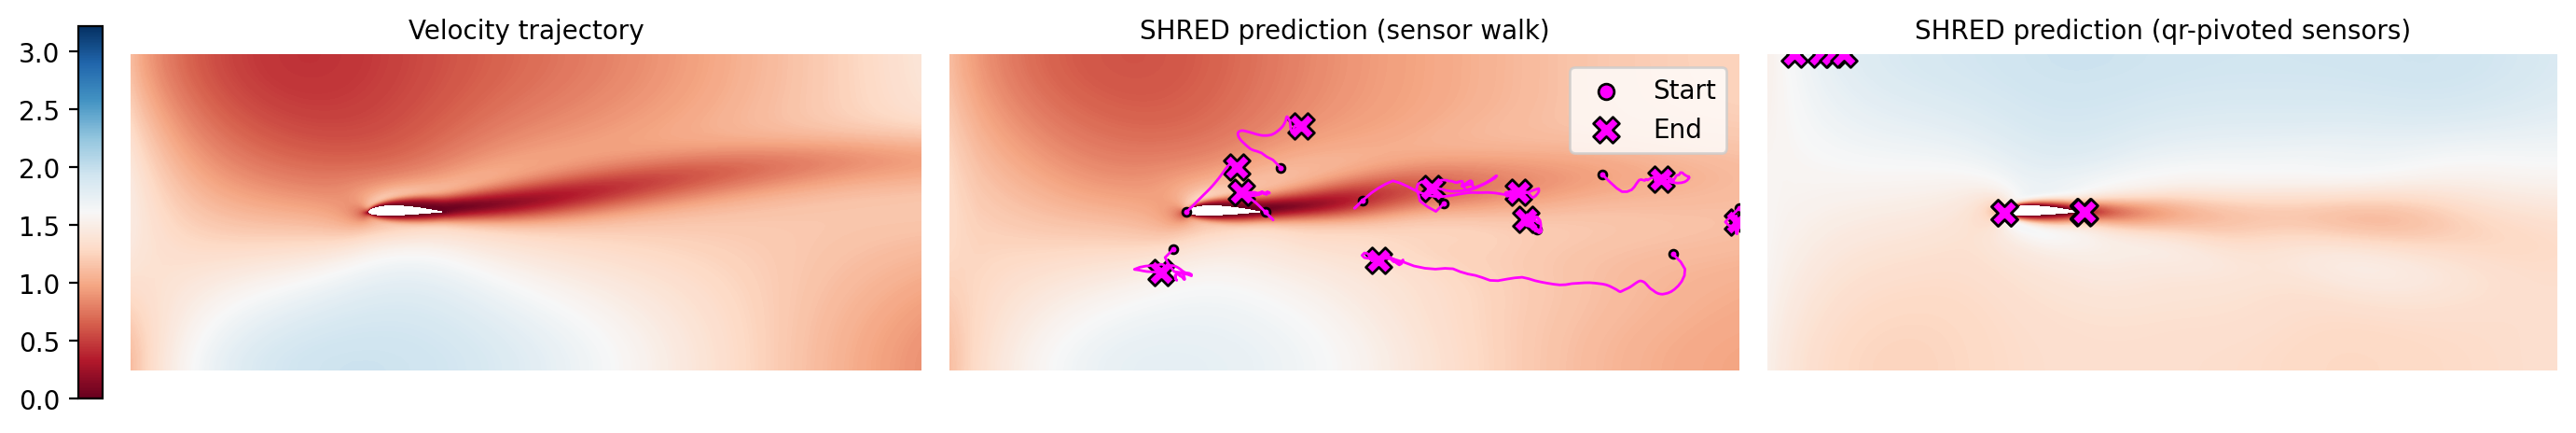

In [ ]:
# # FOM vs POD RECONSTRUCTION (PLOTS)
# import utils.processdata
# importlib.reload(utils.processdata)
# from utils.processdata import trajectories_with_sensors

whichtimes = np.arange(0, 200, 10)

plotlist = [
            Vtest[whichtrajectory, whichtimes],
            Vtest_hat.numpy()[0, whichtimes],
            Vtest_hat_qrpiv.numpy()[0, whichtimes],
            # Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[0, whichtimes],
            ]
titles = (
          "Velocity trajectory",
          "SHRED prediction (sensor walk)",
          "SHRED prediction (qr-pivoted sensors)",
          # "Prediction error",
          )
sensors_coordinates_list  = [
                             [],
                             sensors_coords_test[0],
                             sensors_coords_test_qrpiv[0],
                             [],
                             ]

params_geo = MUtest[whichtrajectory, 0, 2:]

# redefine plot_v on new triang
_, triang = update_coords_and_triang(params_geo)
def plot_v(v, triang = triang, norm = None, cmap = cmap):
    if not norm == None:
        plt.tricontourf(triang, v, cmap = cmap, norm = norm, levels = 200)
    else:
        plt.tricontourf(triang, v, cmap = cmap, levels = 200)
    plt.gca().set_aspect("equal")
    add_zoom(zoom = 1.1)

trajectories_with_sensors(plotlist, plot_v, sensors_coordinates_list,
                          titles = titles,
                          figsize = (10, 5), vertical = False, save = False,
                          # cmap = cmap,
                          cmap = "RdBu_r"
                          # plot_sensors = False,
                          )
# trajectories_with_sensors(plotlist, plot_v, idx_sensors, sensors_coords_test[:4][whichtrajectory].detach().cpu().numpy(), titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"), figsize = (10, 5), vertical = False, save = True)

### Error sensitivity

In [ ]:
# # calcolo l’output del tuo modello e la loss J
# sensors_coords = torch.rand(nsensors, d, device=device, requires_grad=True)
# sensors_coords.data.mul_(torch.tensor([L, H], device=device, dtype=torch.float32))

# timeseries = train_dataset.X.transpose(1,2).contiguous().to(device)
# pred = model(timeseries, sensors_coords.unsqueeze(0).expand(len(timeseries), -1, -1).contiguous())
# loss = mse(pred, data_out)  # J

# # backprop
# loss.backward()

# # i gradienti sono in sensors.grad
# grads = sensors_coords.grad  # shape [N,2], grads[i,0]=∂J/∂x_i, grads[i,1]=∂J/∂y_i
# import matplotlib.pyplot as plt

# xy = sensors_coords.detach().cpu().numpy()
# dx, dy = -grads[:,0].cpu().numpy(), -grads[:,1].cpu().numpy()

# plt.figure(figsize=(6,6))
# plt.quiver(xy[:,0], xy[:,1], dx, dy, angles='xy', scale_units='xy', scale=1)
# plt.xlim(0, L); plt.ylim(0, H)
# plt.title("Sensitività dei sensori (gradiente di J)")
# plt.xlabel("x"); plt.ylabel("y")
# plt.show()

In [ ]:
# XY = np.concatenate((np.expand_dims(X, -1), np.expand_dims(Y, -1)), -1)
# XY = XY.reshape(-1, 2)

In [ ]:
# # pseudo-codice
# X, Y = np.meshgrid(np.linspace(0,L,100), np.linspace(0,H,100))
# S = np.zeros_like(X)
# for i in range(100):
#   print(f"i : {i}")
#   for j in range(100):
#     model.train()
#     sens = sens = torch.tensor(
#           [[ X[i,j], Y[i,j] ]],
#           dtype=torch.float32,
#           requires_grad=True,
#           device=device
#     )  # sens è leaf e will accumulate grad
#     sensor_data = sensor_interpolator(
#             sens.to(device),
#             Vxtest[whichtrajectory].unsqueeze(0).to(device),
#             node_encodings.to(device),
#         )
#     timeseries = Padding(sensor_data, lag).transpose(1,2).contiguous().to(device)
#     J_ij = mse(data_out, model(timeseries, sens.unsqueeze(0).expand(len(timeseries), -1, -1).contiguous()))
#     J_ij.backward()
#     S[i,j] = torch.norm(sens.grad).item()


In [ ]:
# S_ = S.copy()
# # i, j = S.argmax().item() // 100,  S.argmax().item() % 100
# # S_[i, j] = S_[i, j+1]

In [ ]:
# fig, ax = plt.subplots()
# # mesh = ax.pcolormesh(X, Y, S_)
# mesh = ax.tricontourf(X.reshape(-1), Y.reshape(-1), S_.reshape(-1))
# ax.set_aspect('equal', adjustable='box')  # qui imposti axis equal
# add_zoom(1.5)
# fig.colorbar(mesh, ax=ax, label="sensibilità", aspect = 20, shrink = 0.45, pad = 0.02)
# plt.fill(naca0012_airfoil_coords[:, 0], naca0012_airfoil_coords[:, 1], facecolor='white',    # interno bianco
#         #  edgecolor='red',      # bordo rosso
#          linewidth=1.5)
# plt.show()

In [ ]:
# min_error_indices = np.where(np.array(train_error_list) <= np.sort(train_error_list)[4])[0]

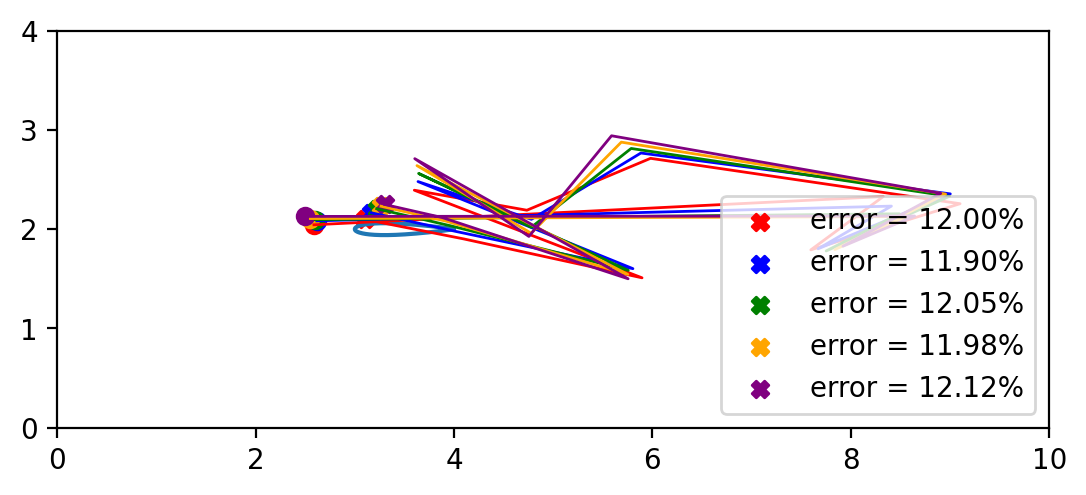

In [ ]:
# plt.figure()
# colors = [
#     'red',
#     'blue',
#     'green',
#     'orange',
#     'purple',
#     'cyan',
#     'magenta',
#     'yellow',
#     'brown',
#     'gray'
# ]
# plt.plot(naca0012_airfoil_coords[:, 0], naca0012_airfoil_coords[:, 1])
# # markers = ["x"] + ["o"] * (len(min_error_indices) - 1)
# for k, i in enumerate(min_error_indices):
#     plt.scatter(sensors_history[i][0, 0], sensors_history[i][0, 1], marker = "X", c = colors[k], label = f"error = {formatter(train_error_list[i])}")
#     plt.scatter(sensors_history[i][-1, 0], sensors_history[i][-1, 1], marker = "o", c = colors[k])
#     # plt.scatter(sensors_history[i][1:, 0], sensors_history[i][1:, 1], marker = "o", c = colors[k], label = f"error = {formatter(train_error_list[i])}")
#     plt.plot(sensors_history[i][:, 0], sensors_history[i][:, 1], c = colors[k], linewidth = 1)
# plt.gca().set_xlim([0, L])
# plt.gca().set_ylim([0, H])
# plt.gca().set_aspect("equal")
# plt.legend()
# plt.show()

# Old

### QR_Pivoting

In [ ]:
from sklearn.utils.extmath import randomized_svd
import scipy

Ux_traj, Sx_traj, Wx_traj = randomized_svd(Vxtest[whichtrajectory].numpy(), n_components = kvelocity//2)
# Uy_traj, Sy_traj, Wy_traj = randomized_svd(Vytest[whichtrajectory].numpy(), n_components = kvelocity//2)

In [ ]:
r = kvelocity//2
n_sensors = kvelocity//2
if (nsensors <= r):
    Q, R, gamma = scipy.linalg.qr(Wx_traj, pivoting = True)
else:
    Q, R, gamma = scipy.linalg.qr(Wx_traj.transpose() @ Wx, pivoting = True)

gamma = gamma[:nsensors] # undersampled

In [ ]:
# Sx = np.load("data/Sx.npy")
# Ux = np.load("data/Ux.npy")

In [ ]:
# Ax = np.diag(Sx_traj) @ Ux_traj.transpose()
# Wx_t = Wx_traj.transpose()

# Ay = np.diag(Sy_traj) @ Uy_traj.transpose()
# Wy_t = Wy_traj.transpose()

In [ ]:
# # sensors_data_test = Vxtest[whichtrajectory, :, gamma]
# Yx = Vxtest[whichtrajectory, :, gamma].numpy().transpose()
# Ax_hat = np.linalg.pinv(Wx_t[gamma, :]) @ Yx # Moore-Penrose pseudo-inverse
# Vxtest_qrpiv = (Wx_t @ Ax_hat).transpose().reshape(ntimes, nvelocity)

# # sensors_data_test = Vxtest[whichtrajectory, :, gamma]
# Yy = Vxtest[whichtrajectory, :, gamma].numpy().transpose()
# Ay_hat = np.linalg.pinv(Wy_t[gamma, :]) @ Yy # Moore-Penrose pseudo-inverse
# Vytest_qrpiv = (Wy_t @ Ay_hat).transpose().reshape(ntimes, nvelocity)


In [ ]:
# Vtest_qrpiv = np.sqrt()

In [ ]:
# # FOM vs POD RECONSTRUCTION VS QR-PIVOTING

# from utils.processdata import trajectories, trajectories_with_sensors

# whichtrajectory = 8
# whichtimes = np.arange(0, 200, 10)

# plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_reconstructed[whichtrajectory, whichtimes], Vxtest_qrpiv[whichtrajectory, whichtimes]]
# params_geo = MUtest[whichtrajectory, 0, 2:]

# # redefine plot_v on new triang
# coords, triang = update_coords_and_triang(params_geo)
# sensors_coordinates = coords[gamma, :2]
# def plot_v(v, triang = triang):
#     plt.tricontourf(triang, v, cmap = cmap, levels = 200)
#     plt.gca().set_aspect("equal")
#     add_zoom(zoom = 1.3)

# vmin = min(np.abs(plotlist[i]).min() for i in range(len(plotlist)))
# vmax = max(np.abs(plotlist[i]).max() for i in range(len(plotlist)))

# trajectories_with_sensors(plotlist, plot_v, gamma, sensors_coordinates, titles = ("Velocity trajectory", "POD reconstruction", "QR-pivoting reconstruction"), figsize = (10, 5), vertical = True)

### Training sensori 3 (prova TPU)


In [ ]:
# !pip install cloud-tpu-client
# !pip install torch-xla torch-xla-core


In [ ]:
os.chdir("../SHRED-ROM")

In [ ]:
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# aggiungi:
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp



In [ ]:
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F

In [ ]:
import importlib
import utils.models
import utils.processdata
importlib.reload(utils.models)
importlib.reload(utils.processdata)
import utils.models
import utils.processdata
from utils.models import SHRED, SHREDagnostic, SHREDTransformer, fit_sensors_coords
from utils.processdata import Padding, TimeSeriesDataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Define custom dataset
class SensorFieldDataset(Dataset):
    def __init__(self, hist, sensor_coords, targets):
        self.hist = hist
        self.sensor_coords = sensor_coords
        self.targets = targets
    def __len__(self):
        return self.hist.size(0)
    def __getitem__(self, idx):
        return (
            self.hist[idx],
            self.sensor_coords[idx],
            self.targets[idx]
        )

In [ ]:
# np.savez_compressed("data/data.npz",

#     Vxtrain = Vxtrain,
#     Vytrain = Vytrain,
#     Vxvalid = Vxvalid,
#     Vyvalid = Vyvalid,
#     Vxtest = Vxtest,
#     Vytest = Vytest,
#     XY = XY,

#     Wx = Wx,
#     Wy = Wy,

#     Vxtrain_POD = Vxtrain_POD,
#     Vxvalid_POD = Vxvalid_POD,
#     Vxtest_POD = Vxtest_POD,

#     Vytrain_POD = Vytrain_POD,
#     Vyvalid_POD = Vyvalid_POD,
#     Vytest_POD = Vytest_POD,

#     MUtrain = MUtrain,
#     MUvalid = MUvalid,
#     MUtest = MUtest,

#     idx_train = idx_train,
#     idx_valid = idx_valid,
#     idx_test = idx_test)

In [ ]:
os.chdir("../my_SHRED-ROM")

In [ ]:
os.environ['XLA_METRICS_DEBUG'] = '1'
# lancia il training


In [ ]:
def _mp_fn(rank, flags):
    # ogni processo XLA vede un solo core
    device = xm.xla_device()

    # -------------------- Data Preparation --------------------
    # Qui carica o ricevi i tuoi array numpy: Vxtrain, Vytrain, etc.
    # Esempio (modifica con i tuoi percorsi / variabili):

    # Print device info and world size
    device = xm.xla_device()
    world_size = xm.xrt_world_size()
    xm.master_print(f"[Core {rank}] Device: {device}, World size: {world_size}")
    xm.master_print(f"[Core {rank}] Flags: {flags}")


    if (rank == 0):
        print("Loading data...")
    data = np.load("data/data.npz")

    Vxtrain = torch.from_numpy(data["Vxtrain"])
    Vytrain = torch.from_numpy(data["Vytrain"])
    Vxvalid = torch.from_numpy(data["Vxvalid"])
    Vyvalid = torch.from_numpy(data["Vyvalid"])
    Vxtest = torch.from_numpy(data["Vxtest"])
    Vytest = torch.from_numpy(data["Vytest"])
    XY = torch.from_numpy(data["XY"])

    Wx = torch.from_numpy(data["Wx"])
    Wy = torch.from_numpy(data["Wy"])

    Vxtrain_POD = torch.from_numpy(data["Vxtrain_POD"])
    Vxvalid_POD = torch.from_numpy(data["Vxvalid_POD"])
    Vxtest_POD = torch.from_numpy(data["Vxtest_POD"])

    Vytrain_POD = torch.from_numpy(data["Vytrain_POD"])
    Vyvalid_POD = torch.from_numpy(data["Vyvalid_POD"])
    Vytest_POD = torch.from_numpy(data["Vytest_POD"])

    MUtrain = torch.from_numpy(data["MUtrain"])
    MUvalid = torch.from_numpy(data["MUvalid"])
    MUtest = torch.from_numpy(data["MUtest"])

    idx_train = torch.from_numpy(data["idx_train"])
    idx_valid = torch.from_numpy(data["idx_valid"])
    idx_test = torch.from_numpy(data["idx_test"])

    if (rank == 0):
        print("Data loaded.")

    # Assume mesh_coords is an array of shape (nvelocity, coord_dim) with node coordinates
    # and idx_sensors is already defined (indices of selected sensors)
    coord_dim = 2  # e.g. 2 for 2D
    lag = 50
    kvelocity = Vxtrain_POD.size(2) * 2
    _, ntimes, nvelocity = Vxtrain.shape

    ntrain = len(idx_train) # number of training trajectories
    nvalid = len(idx_valid)
    ntest = len(idx_test)
    nsensors = flags["nsensors"]

    n_sensors_choices_per_trajectory = 1
    sensors_data_train = torch.zeros((n_sensors_choices_per_trajectory * ntrain, ntimes, nsensors))
    train_hist = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, nsensors, lag))
    train_out = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, kvelocity + 1))
    sensor_coords = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, nsensors, coord_dim))

    for i in range(n_sensors_choices_per_trajectory):
        sensors_idx_train = np.stack([
            np.random.choice(nvelocity, nsensors, replace=False)
            for _ in range(n_sensors_choices_per_trajectory * ntrain)
        ], axis=0)    # (n_sensors_choices_per_trajectory * ntrain, nsensors)

        # sensors_idx_train = indices[idx_train]       # (ntrain,5)
        traj_idx_train    = np.arange(ntrain)[:, None, None]   # (ntrain,1,1)
        time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)
        # sensors_idx_train = sensors_idx_train[:, None, :]      # (ntrain,1,5)
        sensors_data_train[i*ntrain : (i+1)*ntrain] = Vxtrain[traj_idx_train, time_idx, sensors_idx_train[:, None, :]] # → (ntrain,201,5)

        train_hist[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = Padding(sensors_data_train, lag).transpose(1,2) #.to(device) # (N_samples, nsensors, lag)
        train_out[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) #.to(device) # (N_samples, nvelocity)

        sensor_coords[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = torch.from_numpy(np.repeat(XY.numpy()[idx_train][np.arange(ntrain)[:, None, None],
                          sensors_idx_train[:, :, None],
                          np.arange(coord_dim)[None, None, :]], repeats=ntimes, axis=0)).to(torch.float) #.to(device)
    # field_coords_exp = torch.from_numpy(np.repeat(XY[idx_train], repeats=ntimes*n_sensors_choices_per_trajectory, axis=0)).to(torch.float) #.to(device)

# 3) Create DataLoaders
    train_dataset = SensorFieldDataset(train_hist, sensor_coords, train_out)
    train_loader = DataLoader(
        train_dataset,
        batch_size=flags['batch_size'],
        shuffle=True,
        num_workers=0,
        drop_last=True
    )
    warmup_loader = DataLoader(
        train_dataset,
        batch_size=flags['warmup_batch_size'],
        shuffle=True,
        num_workers=0,
        drop_last=True
    )
    xm.master_print(f"[Core {rank}] train_loader batches={len(train_loader)}, warmup_loader batches={len(warmup_loader)}")

    # 4) Model & optimizer
    model = SHREDagnostic(
        coord_dim=XY.size(2),
        latent_dim=flags['latent_dim'],
        output_size=train_out.size(1),
        hidden_size=flags['hidden_size'],
        lstm_layers=flags['lstm_layers'],
        decoder_sizes=flags['decoder_sizes'],
        dropout=flags['dropout']
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=flags['lr'])
    xm.master_print(f"[Core {rank}] Model on {device}, optimizer lr={flags['lr']}")

    # 5) Warm-up with smaller batch
    xm.master_print(f"[Core {rank}] Warm-up: {flags['warmup_steps']} steps, batch_size={flags['warmup_batch_size']}")
    for step, (h, c, t) in enumerate(warmup_loader, 1):
        h, c, t = h.to(device), c.to(device), t.to(device)
        xm.master_print(f"[Core {rank}] Warm-up step {step}: h={h.shape}, c={c.shape}, t={t.shape}")
        _ = model(h, c)
        if step >= flags['warmup_steps']:
            xm.master_print(f"[Core {rank}] Warm-up reached {step} steps")
            break
    xm.mark_step()
    xm.master_print(f"[Core {rank}] Warm-up complete; graph compiled")

    # 6) Prepare ParallelLoader for training
    # Note: in notebooks spawn may run only on core 0.
    device_train_loader = pl.ParallelLoader(train_loader, [device]).per_device_loader(device)

    # 7) Training loop
    for epoch in range(1, flags['epochs'] + 1):
        xm.master_print(f"[Core {rank}] Starting epoch {epoch}/{flags['epochs']}")
        total_loss = 0.0
        for batch_idx, (hist, coords, target) in enumerate(device_train_loader, 1):
            xm.master_print(f"[Core {rank}] Epoch {epoch}, batch {batch_idx}")
            optimizer.zero_grad()
            pred = model(hist, coords)
            loss = F.mse_loss(pred, target)
            xm.master_print(f"[Core {rank}] Loss: {loss.item():.6f}")
            loss.backward()
            xm.optimizer_step(optimizer, barrier=True)
            xm.mark_step()
            total_loss += loss.item() * hist.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        xm.master_print(f"[Core {rank}] Epoch {epoch} done: avg_loss={avg_loss:.6f}")

    # 8) Save checkpoint
    if rank == 0:
        ckpt_path = os.path.join(flags['output_dir'], 'model_tpu.pth')
        torch.save(model.state_dict(), ckpt_path)
        xm.master_print(f"Checkpoint saved: {ckpt_path}")


In [ ]:
if __name__ == '__main__':
    # Check available XLA devices before spawn
    supported = xm.get_xla_supported_devices()
    print("Supported XLA devices:", supported)
    flags = {
        'nsensors': 5,
        'lag': 50,
        'nsensors': 5,
        'batch_size': 1024,
        'warmup_batch_size': 128,
        'latent_dim': 128,
        'hidden_size': 64,
        'lstm_layers': 2,
        'decoder_sizes': [350, 400],
        'dropout': 0.1,
        'lr': 1e-3,
        'epochs': 100,
        'warmup_steps': 20,
        'output_dir': './'
    }
    # Spawn processes (use nprocs=None to use all devices; in notebooks may still run single process)
    xmp.spawn(_mp_fn, args=(flags,), nprocs=None, start_method='fork')



In [ ]:
!python shred_tpu.py

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# per singola TPU core:
# device = xm.xla_device()

In [ ]:
Vxtrain = torch.from_numpy(Vxtrain)
Vytrain = torch.from_numpy(Vytrain)
Vxvalid = torch.from_numpy(Vxvalid)
Vyvalid = torch.from_numpy(Vyvalid)
Vxtest = torch.from_numpy(Vxtest)
Vytest = torch.from_numpy(Vytest)
XY = torch.from_numpy(XY)

Wx = torch.from_numpy(Wx)
Wy = torch.from_numpy(Wy)

Vxtrain_POD = torch.from_numpy(Vxtrain_POD)
Vxvalid_POD = torch.from_numpy(Vxvalid_POD)
Vxtest_POD = torch.from_numpy(Vxtest_POD)

Vytrain_POD = torch.from_numpy(Vytrain_POD)
Vyvalid_POD = torch.from_numpy(Vyvalid_POD)
Vytest_POD = torch.from_numpy(Vytest_POD)

MUtrain = torch.from_numpy(MUtrain)
MUvalid = torch.from_numpy(MUvalid)
MUtest = torch.from_numpy(MUtest)

In [ ]:
# Assume mesh_coords is an array of shape (nvelocity, coord_dim) with node coordinates
# and idx_sensors is already defined (indices of selected sensors)
coord_dim = 2  # e.g. 2 for 2D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lag = 50

In [ ]:
ntrain = len(idx_train) # number of training trajectories
nvalid = len(idx_valid)
ntest = len(idx_test)

In [ ]:
n_sensors_choices_per_trajectory = 1
sensors_data_train = torch.zeros((n_sensors_choices_per_trajectory * ntrain, ntimes, nsensors))
train_hist = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, nsensors, lag))
train_out = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, kvelocity + 1))
sensor_coords_exp = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, nsensors, coord_dim))

In [ ]:
for i in range(n_sensors_choices_per_trajectory):
    sensors_idx_train = np.stack([
        np.random.choice(nvelocity, nsensors, replace=False)
        for _ in range(n_sensors_choices_per_trajectory * ntrain)
    ], axis=0)    # (n_sensors_choices_per_trajectory * ntrain, nsensors)

    # sensors_idx_train = indices[idx_train]       # (ntrain,5)
    traj_idx_train    = np.arange(ntrain)[:, None, None]   # (ntrain,1,1)
    time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)
    # sensors_idx_train = sensors_idx_train[:, None, :]      # (ntrain,1,5)
    sensors_data_train[i*ntrain : (i+1)*ntrain] = Vxtrain[traj_idx_train, time_idx, sensors_idx_train[:, None, :]] # → (ntrain,201,5)

    train_hist[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = Padding(sensors_data_train, lag).transpose(1,2) #.to(device) # (N_samples, nsensors, lag)
    train_out[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) #.to(device) # (N_samples, nvelocity)

    sensor_coords_exp[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = torch.from_numpy(np.repeat(XY.numpy()[idx_train][np.arange(ntrain)[:, None, None],
                      sensors_idx_train[:, :, None],
                      np.arange(coord_dim)[None, None, :]], repeats=ntimes, axis=0)).to(torch.float) #.to(device)
# field_coords_exp = torch.from_numpy(np.repeat(XY[idx_train], repeats=ntimes*n_sensors_choices_per_trajectory, axis=0)).to(torch.float) #.to(device)


In [ ]:
# Instantiate datasets and loaders
train_dataset = SensorFieldDataset(train_hist, sensor_coords_exp, train_out)
# Similarly for valid and test
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


In [ ]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)

model = model.to(device)

In [ ]:
# Instantiate model (using the modified SHRED)
# latent_dim chosen as you prefer
latent_dim = 128
model = SHREDagnostic(coord_dim=coord_dim,
              latent_dim=latent_dim,
              output_size=train_out.shape[1],
              hidden_size=64,
              lstm_layers=2,
              decoder_sizes=[350, 400, train_out.shape[1]],
              dropout=0.1)

# Training loop
def fit_agnostic(model, train_loader, valid_loader=None, epochs=100, lr=1e-3, loss_fun=torch.nn.MSELoss(), loss_output=mre):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': []}

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for k, (hist, s_coords, target) in enumerate(train_loader):
            # print(f"batch {k}")
            optimizer.zero_grad()
            pred = model(hist.to(device, non_blocking=True), s_coords.to(device, non_blocking=True))
            loss = loss_fun(pred, target.to(device, non_blocking=True))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * hist.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_loss)
        print(f"Epoch {epoch}/{epochs}, Train Loss: {avg_loss:.6f}")
    return history

In [ ]:
def fit_agnostic_tpu(model, train_loader, epochs=100, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': []}

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for k, (hist, s_coords, target) in enumerate(train_loader):
            # porta tutto su TPU
            print("batch k")
            hist = hist.to(device, non_blocking=True)
            s_coords = s_coords.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            optimizer.zero_grad()
            pred = model(hist, s_coords)
            loss = F.mse_loss(pred, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * hist.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_loss)

    return history


In [ ]:
def _mp_fn(rank, flags):
    # rank identifica il core, flags può contenere iperparametri
    device = xm.xla_device()
    # ricrea dataset, modello, loader... ma porta tutto su `device`
    model = SHREDagnostic(...).to(device)
    train_loader = DataLoader(..., num_workers=0)
    history = fit_agnostic_tpu(model, train_loader, epochs=100, lr=1e-3)

In [ ]:
# # Run training
# history = fit_agnostic(model, train_loader, epochs=400, lr=1e-3)
# history = fit_agnostic_tpu(model, train_loader, epochs=400, lr=1e-3)


In [ ]:
# Assumendo che `model` sia un'istanza di SHREDagnostic
# torch.save(model.state_dict(), "shred_agnostic.pth")
# model.load_state_dict(torch.load( "shred_agnostic.pth", weights_only=True, map_location=torch.device('cpu')))
# model.eval()


In [ ]:
torch.cuda.empty_cache()

NameError: name 'torch' is not defined

In [ ]:
from matplotlib.colors import Normalize
from matplotlib import cm
import imageio
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.transforms import Bbox

def trajectories_with_sensors(yts, plot, sensors_coordinates, cmap=None, titles=None, fontsize=None, figsize=None, vertical=False, axis=False, save=False, name='gif', vmin=None, vmax=None):
    arrays = []
    num_sensors = len(sensors_coordinates)

    if vmin is not None or vmax is not None:
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        norm = None

    for i in range(yts[0].shape[0]):
        fig, axs = plt.subplots(len(yts) if vertical else 1, 1 if vertical else len(yts), figsize=figsize)
        axs = np.atleast_1d(axs)

        for j, ax in enumerate(axs):
            plt.sca(ax)
            plot(yts[j][i], norm=norm)
            if j == len(yts) - 2:
                for k in range(num_sensors):
                    ax.plot(sensors_coordinates[k, 0], sensors_coordinates[k, 1], 'o', mfc='magenta', mec='black', ms=8, mew=1.5)
            if titles:
                ax.set_title(titles[j], fontsize=fontsize)
            if not axis:
                ax.axis('off')

        plt.colorbar(
              cm.ScalarMappable(cmap=cmap, norm=norm),
              # ax=axs[0],
              cax = fig.add_axes([-0.01, 0.35, 0.01, 0.3]),
              location="left",
              orientation="vertical",
              pad=0.02,           # più piccolo = meno distanza
              fraction=0.04,      # più piccolo = colorbar più sottile
              aspect=40           # opzionale, controlla il rapporto larghezza/altezza
            )

        fig.tight_layout()
        display(fig)
        if save:
            fig.canvas.draw()
            arrays.append(np.array(fig.canvas.renderer.buffer_rgba()))
        plt.close()
        clc(wait=True)

    if save:
        imageio.mimsave(name.replace(".gif", "") + ".gif", arrays)


In [ ]:
mult = 1
nsensors_test = int(nsensors * mult)
whichtrajectory = 4 # np.random.choice(ntest)

sensors_idx_test = np.random.choice(nvelocity, nsensors_test, replace=False)
# sensors_idx_test = sensors_idx_test[None, :]      # (1, nsensors_test)

# sensors_data_test = Vxtest[traj_idx_test, time_idx, sensors_idx_test].unsqueeze(0) (1, ntimes, nsensors_test)
sensors_data_test = Vxtest[whichtrajectory, :, sensors_idx_test].unsqueeze(0) # (1, ntimes, nsensors_test)
test_hist = Padding(sensors_data_test, lag).transpose(1,2) # (ntimes, lag, nsensors_test)

sensors_coords_test = XY[idx_test][whichtrajectory][sensors_idx_test].unsqueeze(0) # (1, nsensors_test, 2)
Vtest_POD = model(test_hist.to(device).contiguous(), sensors_coords_test.repeat(ntimes, 1, 1).to(device))[:, :-1]
Vtest_hat = torch.sqrt((torch.from_numpy(scalerVx.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,:kvelocity//2])).float() @ Wx).view(1, ntimes, nvelocity)**2 \
                       + \
                       (torch.from_numpy(scalerVy.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,kvelocity//2:])).float() @ Wy).view(1, ntimes, nvelocity)**2)

In [ ]:
# # FOM vs POD RECONSTRUCTION (PLOTS)
# import utils.processdata
# importlib.reload(utils.processdata)
# from utils.processdata import trajectories_with_sensors

whichtimes = np.arange(0, 200, 20)

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat.numpy()[0, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[0, whichtimes]]
params_geo = MUtest[whichtrajectory, 0, 2:]

# redefine plot_v on new triang
_, triang = update_coords_and_triang(params_geo)
def plot_v(v, triang = triang, norm = None):
    if not norm == None:
        plt.tricontourf(triang, v, cmap = cmap, norm = norm, levels = 200)
    else:
        plt.tricontourf(triang, v, cmap = cmap, levels = 200)
    plt.gca().set_aspect("equal")
    add_zoom(zoom = 1.1)

vmin = min(np.abs(plotlist[i]).min() for i in range(len(plotlist)))
vmax = max(np.abs(plotlist[i]).max() for i in range(len(plotlist)))

trajectories_with_sensors(plotlist, plot_v, sensors_coords_test[0],
                          titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"),
                          figsize = (10, 5), vertical = False, save = False,
                          vmin = vmin, vmax = vmax, cmap = cmap)
# trajectories_with_sensors(plotlist, plot_v, idx_sensors, sensors_coords_test[:4][whichtrajectory].detach().cpu().numpy(), titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"), figsize = (10, 5), vertical = False, save = True)

### Training sensori 2 (rigenero tutto il dataset con coordinate sensori)

In [ ]:
import torch
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F
from utils.processdata import TimeSeriesDataset, Padding

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
Vxtrain_POD = torch.from_numpy(Vxtrain_POD)
Vxvalid_POD = torch.from_numpy(Vxvalid_POD)
Vxtest_POD = torch.from_numpy(Vxtest_POD)

Vytrain_POD = torch.from_numpy(Vytrain_POD)
Vyvalid_POD = torch.from_numpy(Vyvalid_POD)
Vytest_POD = torch.from_numpy(Vytest_POD)

MUtrain = torch.from_numpy(MUtrain)
MUvalid = torch.from_numpy(MUvalid)
MUtest = torch.from_numpy(MUtest)


In [ ]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 50

# train_data_in = Padding(sensors_data_train, lag).to(device)
# valid_data_in = Padding(sensors_data_valid, lag).to(device)
# test_data_in = Padding(sensors_data_test, lag).to(device)


In [ ]:
# # EXTRACT SENSOR DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)
# idx_sensors = np.random.choice(nvelocity, size = nsensors, replace = False)

In [ ]:
# Assume mesh_coords is an array of shape (nvelocity, coord_dim) with node coordinates
# and idx_sensors is already defined (indices of selected sensors)
coord_dim = 2  # e.g. 2 for 2D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lag = 50

In [ ]:
# dopo Vxtrain = Vxfull[idx_train]
ntrain = len(idx_train)    # es. 64
nvalid = len(idx_valid)
ntest = len(idx_test)

# 1) genera indici random sulle 80 traiettorie
indices = np.stack([
    np.random.choice(nvelocity, nsensors, replace=False)
    for _ in range(ntrajectories)
], axis=0)    # (80,5)

# 2) ma per train prendi solo quelli di idx_train
sensors_idx_train = indices[idx_train]       # (ntrain,5)

# 3) ricostruisci un "traj_idx" che vada da 0 a ntrain-1
traj_idx_train    = np.arange(ntrain)[:, None, None]   # (ntrain,1,1)
time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)
sensors_idx_train = sensors_idx_train[:, None, :]      # (ntrain,1,5)

# 4) slicedata su Vxtrain
sensors_data_train = torch.from_numpy(
    Vxtrain[traj_idx_train, time_idx, sensors_idx_train]
).float()   # → (ntrain,201,5)


In [ ]:
train_hist = Padding(sensors_data_train, lag).transpose(1,2) #.to(device) # (N_samples, nsensors, lag)
train_out = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) #.to(device) # (N_samples, nvelocity)

# valid_hist = Padding(sensors_data_valid, lag).to(device) # (N_samples, lag, nsensors)
# valid_out = Padding(torch.cat((Vxvalid_POD, Vyvalid_POD, MUvalid[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1).to(device) # (N_samples, nvelocity)

# test_hist = Padding(sensors_data_test, lag).to(device) # (N_samples, lag, nsensors)
# test_out = Padding(torch.cat((Vxtest_POD, Vytest_POD, MUtest[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1).to(device) # (N_samples, nvelocity)

# Number of samples
N_train = train_hist.shape[0]

# Expand coords to per-sample
sensor_coords_exp = torch.from_numpy(np.repeat(XY[np.arange(ntrajectories)[:, None], indices][idx_train], repeats=ntimes, axis=0)).to(torch.float) #.to(device)
field_coords_exp = torch.from_numpy(np.repeat(XY[idx_train], repeats=ntimes, axis=0)).to(torch.float) #.to(device)

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Define custom dataset
class SensorFieldDataset(Dataset):
    def __init__(self, hist, sensor_coords, field_coords, targets):
        self.hist = hist
        self.sensor_coords = sensor_coords
        self.field_coords = field_coords
        self.targets = targets
    def __len__(self):
        return self.hist.size(0)
    def __getitem__(self, idx):
        return (
            self.hist[idx],
            self.sensor_coords[idx],
            self.field_coords[idx],
            self.targets[idx]
        )

# Instantiate datasets and loaders
train_dataset = SensorFieldDataset(train_hist, sensor_coords_exp, field_coords_exp, train_out)
# Similarly for valid and test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
import importlib
import utils.models
import utils.processdata
importlib.reload(utils.models)
importlib.reload(utils.processdata)
import utils.models
import utils.processdata
from utils.models import SHRED, SHREDagnostic, SHREDTransformer, fit_sensors_coords
from utils.processdata import Padding, TimeSeriesDataset

In [ ]:
# Instantiate model (using the modified SHRED)
# latent_dim chosen as you prefer
latent_dim = 128
model = SHREDagnostic(coord_dim=coord_dim,
              latent_dim=latent_dim,
              output_size=train_out.shape[1],
              hidden_size=64,
              lstm_layers=2,
              decoder_sizes=[350, 400, train_out.shape[1]],
              dropout=0.1).to(device)

# Training loop
def fit_agnostic(model, train_loader, valid_loader=None, epochs=100, lr=1e-3, loss_fun=torch.nn.MSELoss(), loss_output=mre):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': []}

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for k, (hist, s_coords, q_coords, target) in enumerate(train_loader):
            # print(f"batch {k}")
            hist, s_coords, q_coords, target = hist.to(device), s_coords.to(device), q_coords.to(device), target.to(device)
            optimizer.zero_grad()
            # pred = model(hist, s_coords, q_coords)  # (B, nvelocity)
            pred = model(hist, s_coords)
            # print(pred.shape)
            loss = loss_fun(pred, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * hist.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_loss)
        print(f"Epoch {epoch}/{epochs}, Train Loss: {avg_loss:.6f}")
    return history

In [ ]:
model.coef_decoder

In [ ]:
# Run training
history = fit_agnostic(model, train_loader, epochs=200, lr=1e-3)


In [ ]:
# 2) ma per train prendi solo quelli di idx_train
sensors_idx_test = indices[idx_test]       # (ntrain,5)

# 3) ricostruisci un "traj_idx" che vada da 0 a ntrain-1
traj_idx_test    = np.arange(ntest)[:, None, None]   # (ntest,1,1)
time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)
sensors_idx_test = sensors_idx_test[:, None, :]      # (ntest,1,5)

# 4) slicedata su Vxtrain
sensors_data_test = torch.from_numpy(
    Vxtest[traj_idx_test, time_idx, sensors_idx_test]
).float()   # → (ntest,201,5)

In [ ]:
test_hist = Padding(sensors_data_test, lag).transpose(1,2).to(device).contiguous() # (N_samples, lag, nsensors)
test_out = Padding(torch.cat((Vxtest_POD, Vytest_POD, MUtest[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) # .to(device) # (N_samples, nvelocity)

sensor_coords_exp_test = torch.from_numpy(np.repeat(XY[np.arange(ntrajectories)[:, None], indices][idx_test], repeats=ntimes, axis=0)).to(torch.float) #.to(device)
field_coords_exp_test = torch.from_numpy(np.repeat(XY[idx_test], repeats=ntimes, axis=0)).to(torch.float) #.to(device)

In [ ]:
del test_out

In [ ]:
N_test = sensor_coords_exp_test.shape[0]

In [ ]:
Vtest_POD = model(test_hist[:N_test].to(device), sensor_coords_exp_test[:N_test].to(device))[:, :-1]


In [ ]:
Wx = torch.from_numpy(Wx)
Wy = torch.from_numpy(Wy)

In [ ]:
Vxtest_hat = torch.from_numpy(scalerVx.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,:kvelocity//2])).to(torch.float32) @ Wx
Vytest_hat = torch.from_numpy(scalerVy.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,kvelocity//2:])).to(torch.float32) @ Wy

In [ ]:
# Vtest_hat = torch.zeros(Ntest, ntimes, nvelocity)
# Vtest_hat[:, :, 0 : nvelocity : 2] = Vxtest_hat.reshape(ntest, ntimes, nvelocity//2)
# Vtest_hat[:, :, 1 : nvelocity : 2] = Vytest_hat.reshape(ntest, ntimes, nvelocity//2)
Vtest_hat = torch.sqrt(Vxtest_hat.view(ntest, ntimes, nvelocity)**2 + Vytest_hat.view(ntest, ntimes, nvelocity)**2)

In [ ]:
# sensors_coords_test = XY[idx_test][:, idx_sensors]

In [ ]:
sensors_coords_test = XY[np.arange(ntrajectories)[:, None], indices][idx_test]

In [ ]:
# FOM vs POD RECONSTRUCTION (PLOTS)

from utils.processdata import trajectories_with_sensors

whichtrajectory = 2
whichtimes = np.arange(0, 200, 10)

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[whichtrajectory, whichtimes]]
params_geo = MUtest[whichtrajectory, 0, 2:]

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[whichtrajectory, whichtimes]]


# redefine plot_v on new triang
_, triang = update_coords_and_triang(params_geo)
def plot_v(v, triang = triang):
    plt.tricontourf(triang, v, cmap = cmap, levels = 200)
    plt.gca().set_aspect("equal")
    add_zoom(zoom = 1.3)

vmin = min(np.abs(plotlist[i]).min() for i in range(len(plotlist)))
vmax = max(np.abs(plotlist[i]).max() for i in range(len(plotlist)))

trajectories_with_sensors(plotlist, plot_v, indices[idx_test][:4][whichtrajectory], sensors_coords_test[:4][whichtrajectory], titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"), figsize = (10, 5), vertical = False, save = True)
# trajectories_with_sensors(plotlist, plot_v, idx_sensors, sensors_coords_test[:4][whichtrajectory].detach().cpu().numpy(), titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"), figsize = (10, 5), vertical = False, save = True)

### Training sensors

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Vxtrain_POD = torch.from_numpy(Vxtrain_POD).to(device)
# Vytrain_POD = torch.from_numpy(Vytrain_POD).to(device)
# MUtrain = torch.from_numpy(MUtrain).to(device)
# # sensors_coords_new = torch.from_numpy(sensors_coords_new).to(device)
# XY = torch.from_numpy(XY).to(device)
# Vxtrain = torch.from_numpy(Vxtrain).to(device)
# Vxvalid = torch.from_numpy(Vxvalid).to(device)
# Vxtest = torch.from_numpy(Vxtest).to(device)

In [ ]:
# Vxtrain_POD = Vxtrain_POD.to(device)
# Vytrain_POD = Vytrain_POD.to(device)
# MUtrain = MUtrain.to(device)
# # sensors_coords_new = torch.from_numpy(sensors_coords_new).to(device)
# XY = XY.to(device)
# Vxtrain = Vxtrain.to(device)
# Vxvalid = Vxvalid.to(device)
# Vxtest = Vxtest.to(device)

In [ ]:
import utils.models
import utils.processdata

ModuleNotFoundError: No module named 'utils'

In [ ]:
import importlib
importlib.reload(utils.models)
importlib.reload(utils.processdata)

In [ ]:
from utils.models import SHRED, SHREDTransformer, SHREDConcat, SHREDPerceiverSpatial
from utils.processdata import Padding, TimeSeriesDataset

In [ ]:
d = 2 # 2D

In [ ]:
# Le posizioni dei sensori sono variabili trainabili
sensors_coords = torch.rand(nsensors, d, device=device, requires_grad=True)
sensors_coords.data.mul_(torch.tensor([L, H], device=device, dtype=torch.float32))

# Inizializza il modello SHRED (o SHREDTransformer)
# Nel tuo caso il modello in input prende la time series dei sensori: shape (ntraj, ntimes, nsensors)
# e produce un output (ad es., dimensione kvelocity+1)

model = SHRED(input_size=nsensors * (d+1), output_size=kvelocity + 1, hidden_size=64, hidden_layers=2,
              decoder_sizes=[350, 400], dropout=0.1).to(device)
# model = SHREDConcat(nsensors, coord_pe_dim = 2*D, output_size=kvelocity + 1, hidden_size=64, hidden_layers=2,
#               decoder_sizes=[350, 400], dropout=0.1).to(device)
# model = SHREDPerceiverSpatial(nsensors, coord_dim = 2 * D, d_model = 64, output_size=kvelocity + 1, hidden_size=64, hidden_layers=2,
#               decoder_sizes=[350, 400], dropout=0.1).to(device)


In [ ]:
plt.figure()
scatter_array(naca0012_airfoil_coords, s = 0.1)
scatter_array(sensors_coords.detach().cpu().numpy(), s = 50)
plt.plot([0, L, L, 0, 0], [0, 0, H, H, 0])
add_zoom()
plt.show()

In [ ]:
# sensor_encodings = fourier_encode(sensors_coords, B).clone().detach().to(device).requires_grad_(True)

In [ ]:
import torch
from torch.utils.data import DataLoader
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F
from utils.processdata import TimeSeriesDataset, Padding

In [ ]:
sensor_interpolator = SensorDataInterpolator(B.to(device)).to(device)  # o device appropriato


In [ ]:
lag = 50
# optim_cls=torch.optim.Adam
lr_shred=1e-3
lr_sensors=0.05
batch_size = ntimes * 2 # deve essere multiplo o divisore di ntimes
batch_size = 67
epochs = 2000
print_every_epochs = 5
update_sensors_every_steps = 20
scatter_sensors_every_steps = epochs

loss_fun = mse
loss_output = mre
formatter = num2p

train_error_list = []

In [ ]:
# Preinizializza l'ottimizzatore con i parametri del modello e anche sensors_coords
# Definisci due ottimizzatori:
optimizer_model = torch.optim.Adam(model.parameters(), lr=lr_shred)           # per il modello SHRED
optimizer_sensors = torch.optim.Adam([sensors_coords], lr=lr_sensors)         # per le coordinate dei sensori

In [ ]:
node_encodings_train = fourier_encode(XY[idx_train].view(-1, XY.shape[-1]), B).view(len(idx_train), nvelocity, -1).to(device)
node_encodings_valid = fourier_encode(XY[idx_valid].view(-1, XY.shape[-1]), B).view(len(idx_valid), nvelocity, -1).to(device)
node_encodings_test = fourier_encode(XY[idx_test].view(-1, XY.shape[-1]), B).view(len(idx_test), nvelocity, -1).to(device)

In [ ]:
train_data_out = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:,:,0].unsqueeze(2)), 2), 1).squeeze(1).to(device)

In [ ]:
sensors_data_train = sensor_interpolator(sensors_coords, Vxtrain, node_encodings_train)  # shape (ntraj, ntimes, nsensors)
sensors_data_valid = sensor_interpolator(sensors_coords, Vxvalid, node_encodings_valid)  # shape (ntraj, ntimes, nsensors)
sensors_data_test = sensor_interpolator(sensors_coords, Vxtest, node_encodings_test)  # shape (ntraj, ntimes, nsensors)

In [ ]:
train_dataset = TimeSeriesDataset(Padding(sensors_data_train, lag).to(device), train_data_out)
test_data_in = Padding(sensors_data_test, lag).to(device)

In [ ]:
Y_loader = DataLoader(train_data_out, shuffle=False, batch_size=batch_size)

In [ ]:
sensors_history = [sensors_coords.detach().cpu().numpy()]

In [ ]:
# sensors_coords_train = np.tile(XY[idx_train][:, idx_sensors], reps = (ntimes, 1, 1))
# sensors_coords_train = torch.from_numpy(sensors_coords_train).to(torch.float32).to(device)

# sensors_coords_valid = np.tile(XY[idx_valid][:, idx_sensors], reps = (ntimes, 1, 1))
# sensors_coords_valid = torch.from_numpy(sensors_coords_valid).to(torch.float32).to(device)

In [ ]:
# dataset = list(zip(sensors_coords_train, train_data_in, train_data_out))

In [ ]:
coords = sensors_coords.unsqueeze(0).unsqueeze(0)
coords_exp = coords.expand(len(idx_train) * ntimes, lag, nsensors, d)
train_data = torch.cat([coords_exp, train_dataset.X.unsqueeze(-1)], dim=-1)
train_data = train_data.view(len(idx_train) * ntimes, lag,
                      nsensors * (d + 1))

In [ ]:
train_data.shape

In [ ]:
X_batch.shape

In [ ]:
# Inizializza la cache per memorizzare i batch calcolati
batch_cache = {}

global_step = 0
for epoch in range(1, epochs + 1):
    # print(f"epoch {epoch}")
    for batch_idx, Y_batch in enumerate(Y_loader):
        model.train()

        # # Calcola l'indice e la finestra temporale per il batch corrente (backup)
        # traj_idx = batch_idx * batch_size // ntimes
        # start_time = (batch_idx % (ntimes // batch_size)) * batch_size
        # end_time = start_time + batch_size

        # Calcola l'indice e la finestra temporale per il batch corrente
        traj_idx = [batch_idx * batch_size // ntimes] if batch_size < ntimes else np.arange(batch_idx * batch_size // ntimes, (batch_idx + 1) * batch_size // ntimes).tolist()
        start_time = (batch_idx % (ntimes // batch_size) if (ntimes // batch_size != 0) else 0) * batch_size
        end_time = start_time + batch_size

        # Definisci una chiave univoca per questo batch
        key = (traj_idx[-1], start_time, end_time)
        # print(key)

        if global_step % update_sensors_every_steps == 0 or key not in batch_cache:
            # print(f"Epoch {epoch}: interpolating...")
            sensors_coords = torch.rand(nsensors, d, device=device, requires_grad=False)
            sensors_coords.data.mul_(torch.tensor([L, H], device=device, dtype=torch.float32))
            sensor_data = sensor_interpolator(
                sensors_coords,
                Vxtrain[traj_idx][:, start_time:end_time],
                node_encodings_train[traj_idx]
            )
            sensor_encodings = fourier_encode(sensors_coords, B).detach()
            # print(sensor_data.shape)
            X_batch = Padding(sensor_data, lag).to(device)
            # print(X_batch.shape)
            batch_cache[key] = X_batch  # salva X_batch nel cache con grafo attivo
        else:
            # Usa il valore in cache ma "detach" per non propagare i gradienti
            X_batch = batch_cache[key].detach()
            # X_batch = gate_gradient(batch_cache[key].clone(), 0.0)

        # Concatenazione con coordinate sensori
        coords = sensors_coords.unsqueeze(0).unsqueeze(0)
        coords_exp = coords.expand(batch_size, lag, nsensors, d)
        X_batch = torch.cat([coords_exp, X_batch.unsqueeze(-1)], dim=-1)
        X_batch = X_batch.view(batch_size,
                              lag,
                              nsensors * (d + 1))

        # Procedi con il resto del forward e backward
        optimizer_model.zero_grad()
        # optimizer_sensors.zero_grad()
        outputs = model(X_batch)
        loss = loss_fun(outputs, Y_batch)
        loss.backward()
        optimizer_model.step()

    # if global_step % update_sensors_every_steps == 0:
    #     optimizer_sensors.step()
    #     # Applica il reflection in-place sui sensori
    #     # sensors_coords.data = reflect_coords(sensors_coords.data, L, H)
    #     sensors_coords.data = reflect_with_grad_flip(sensors_coords.data, L, H)

    global_step += 1

    if global_step % update_sensors_every_steps == 0:
        # sensors_history.append(fourier_decode(sensor_encodings.cpu()).detach().cpu().numpy())
        sensors_history.append(sensors_coords.detach().cpu().numpy())
    # Logging e validazione
    if epoch % print_every_epochs == 0:
        model.eval()
        with torch.no_grad():
            train_error = loss_output(train_dataset.Y, model(train_data))
            train_error_list.append(train_error)
        print(f"Epoch {epoch}: Training loss = {formatter(train_error_list[-1])}")

    if epoch % scatter_sensors_every_steps == 0:
        print(sensors_coords.detach().cpu().numpy())

NameError: name 'epochs' is not defined

In [ ]:
model.mix

In [ ]:
colors = [
    'red',
    'blue',
    'green',
    'orange',
    'purple',
    'cyan',
    'magenta',
    'yellow',
    'brown',
    'gray'
]

In [ ]:
plt.figure()

# Airfoil senza label
scatter_array(naca0012_airfoil_coords, s=0.1, label='_nolegend_')

# Dominio senza label
plt.plot([0, L, L, 0, 0], [0, 0, H, H, 0], label='_nolegend_')

# Numero di sensori
num_sensors = len(sensors_history[0])

for i in range(num_sensors):
    traj = np.array([step[i] for step in sensors_history])

    # Linea della traiettoria
    plt.plot(traj[:, 0], traj[:, 1], color=colors[i], label=f'Sensor {i+1}', linewidth = 1)

    # Marker inizio con colore della linea
    plt.scatter(traj[0, 0], traj[0, 1], color=colors[i], edgecolors='k', marker='o', s=100, label='_nolegend_')

    # Marker fine con colore della linea
    plt.scatter(traj[-1, 0], traj[-1, 1], color=colors[i], edgecolors='k', marker='X', s=100, label='_nolegend_')

# Aggiungi marker "Start" e "End" alla legenda con solo bordo nero
plt.scatter([], [], facecolors='none', edgecolors='k', marker='o', s=100, label='Start')
plt.scatter([], [], facecolors='none', edgecolors='k', marker='X', s=100, label='End')

plt.title("Traiettorie dei sensori")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
add_zoom()
plt.show()


### Positional encoding 2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
traj_id = [20]

In [ ]:
train_trajectories = len(idx_train)
train_trajectories

In [ ]:
!pip install pydoe

In [ ]:
from pyDOE import lhs

In [ ]:
nsensors = 2000

In [ ]:
# sensors_coords_new = np.concatenate((np.random.rand(nsensors, 1) * (xmax - xmin) + xmin, np.random.rand(nsensors, 1) * (ymax - ymin) + ymin), 1, dtype = np.float32)
sensors_coords_new = lhs(2, nsensors) * [L, H]
sensors_coords_new = torch.from_numpy(sensors_coords_new).to(torch.float32)
# XY = torch.from_numpy(XY)
# Vxtrain = torch.from_numpy(Vxtrain)

In [ ]:
import torch
import torch.nn.functional as F

# --------------------------------------------------
# 1. Definizione della funzione di Fourier Positional Encoding
# --------------------------------------------------
def fourier_encode(x, B):
    """
    Applica il positional encoding Fourier alle coordinate.

    Parametri:
      - x: tensor di shape (n, d) (ad esempio, coordinate spaziali)
      - B: tensor di shape (d, D) contenente le frequenze.

    Restituisce:
      - encoding: tensor di shape (n, 2*D) ottenuto concatenando sin(xB) e cos(xB).
    """
    # Proiezione: x @ B produce un tensore di shape (n, D)
    x_proj = 2 * torch.pi * x @ B
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# --------------------------------------------------
# 2. Setup dei parametri e degli input
# --------------------------------------------------
d = 2   # dimensione originale delle coordinate (x, y)
D = 16  # dimensione scelta per la proiezione (puoi variare questo parametro)

# Matrice di frequenze per il Fourier encoding (può essere fissata oppure resa learnable)
B = torch.randn(d, D).to(device)

# --------------------------------------------------
# 3. Calcolo degli encoding Fourier per i nodi e per i sensori
# --------------------------------------------------
# Calcolo dell'encoding per i sensori: shape (nsensors, 2*D)
sensor_encodings = fourier_encode(sensors_coords_new, B)  # comune a tutte le traiettorie

# Calcolo dell'encoding per i nodi per tutte le traiettorie.
# Risultato atteso: (ntraj, nvelocity, 2*D)
# Possiamo calcolarlo in modo vettorizzato:

node_encodings_train = fourier_encode(XY[idx_train][traj_id].view(-1, d), B)
# node_encodings_train = node_encodings_train.view(len(idx_train), nvelocity, 2 * D)
node_encodings_train = node_encodings_train.view(len([traj_id]), nvelocity, 2 * D)

# node_encodings_valid = fourier_encode(XY[idx_valid].view(-1, d), B)
# node_encodings_valid = node_encodings_valid.view(len(idx_valid), nvelocity, 2 * D)

# node_encodings_test = fourier_encode(XY[idx_test].view(-1, d), B)
# node_encodings_test = node_encodings_test.view(len(idx_test), nvelocity, 2 * D)

In [ ]:
# --------------------------------------------------
# 4. Calcolo dei pesi di similarità e interpolazione
# --------------------------------------------------
# Per ogni traiettoria, calcoliamo la similarità fra i sensori e i nodi.
# Usiamo broadcasting per ottenere in una sola operazione:
#
#   sensor_encodings: (nsensors, 2*D)
#   node_encodings: (ntraj, nvelocity, 2*D)
#
# Vogliamo ottenere similarity: (ntraj, nsensors, nvelocity)
# facendo, per ogni traiettoria i e per ogni sensore j,
#   similarity[i,j] = sensor_encodings[j] · node_encodings[i].T
sensor_encodings_expanded = sensor_encodings.unsqueeze(0)  # shape: (1, nsensors, 2*D)


In [ ]:
# Trasponiamo l'encoding dei nodi per il prodotto scalare:
node_encodings_t = node_encodings_train  # shape: (ntraj, nvelocity, 2*D)
similarity = torch.matmul(sensor_encodings_expanded, node_encodings_t.transpose(1,2))
# similarity: (ntraj, nsensors, nvelocity)

# Otteniamo i pesi (softmax sul nodo-dimensione, ovvero dim=2)
weights = F.softmax(similarity, dim=2)  # shape: (ntraj, nsensors, nvelocity)

# Ora, per ogni traiettoria e per ogni timestep, eseguiamo la media pesata dei valori dei nodi.
# Vxtrain ha shape: (ntraj, ntimes, nvelocity)
# Per eseguire la moltiplicazione, trasponiamo weights in modo che abbiano shape (ntraj, nvelocity, nsensors)
weights_t = weights.transpose(1,2)  # shape: (ntraj, nvelocity, nsensors)

sensors_data_train = torch.matmul(Vxtrain[traj_id], weights_t)

In [ ]:
scatter_array(naca0012_coords, s = 0.1)
scatter_array(sensors_coords_new, s = 50)
add_zoom()

In [ ]:
# TRAJECTORY WITH SENSORS (PLOT)
import matplotlib as mpl

def trajectory_with_sensors(vt, params_geo, sensors_coordinates, sensors_values, title = None):
    """
    Velocity trajectory with sensors
    Input: velocity trajectory with dimension (ntimes, nvelocity), geometric parameters and and the selected sensor indices
    """
    # redefine plot_v on new triang
    coords, triang = update_coords_and_triang(params_geo)
    norm = mpl.colors.Normalize(vmin = vt.min().item(), vmax = vt.max().item())
    def plot_v(v, triang = triang):
        plt.tricontourf(triang, v, cmap = cmap, levels = 200, norm = norm)
        plt.gca().set_aspect("equal")
        add_zoom(zoom = 1.3)

    # sensors_coordinates = coords[idx_sensors, :2]
    nsensors = sensors_coordinates.shape[0]

    for i in range(vt.shape[0]):
        plt.figure(figsize=(10,10))
        # plot_v(vt[i])
        for k in np.arange(nsensors):
            plt.scatter(sensors_coordinates[k, 0], sensors_coordinates[k, 1], c = sensors_values[i, k],
                        facecolors='none',   # interno trasparente
                        edgecolors='white',
                        marker = 'o', norm = norm, s = 100, cmap = cmap) # , mec = 'black', ms = 8, mew = 1.5)
        plt.xlim((-0.1,10.1))
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

# whichtrajectory = 3
whichtrajectory = 0
whichtimes = np.arange(0, 200, 10)

trajectory_with_sensors(Vxtrain[whichtrajectory, whichtimes],
                        MUtrain[whichtrajectory, 0, 2:],
                        sensors_coordinates=sensors_coords_new,
                        sensors_values= sensors_data_train.detach().numpy()[whichtrajectory, whichtimes],
                        title = "Velocity trajectory with sensors")

NameError: name 'np' is not defined

### Training

In [ ]:
np.random.seed(41)

In [ ]:
# # Simuliamo 5 sensori, ma ad ogni training step le loro coordinate cambiano
nsensors = 5
[xmin, xmax, ymin, ymax] = geometry = [0, 10, 0, 4]
# sensors_coords_new = np.concatenate((np.random.rand(nsensors, 1) * (xmax - xmin) + xmin, np.random.rand(nsensors, 1) * (ymax - ymin) + ymin), 1, dtype = np.float32)


In [ ]:
# EXTRACT SENSOR DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)
idx_sensors = np.random.choice(nvelocity, size = nsensors, replace = False)

sensors_data_train = Vxtrain[:,:,idx_sensors]
sensors_data_valid = Vxvalid[:,:,idx_sensors]
sensors_data_test = Vxtest[:,:,idx_sensors]

In [ ]:
# # sensors_data_train = torch.from_numpy(sensors_data_train)
# # sensors_data_valid = torch.from_numpy(sensors_data_valid)
# # sensors_data_test = torch.from_numpy(sensors_data_test)

# # Vxtrain_POD = torch.from_numpy(Vxtrain_POD)
# Vxvalid_POD = torch.from_numpy(Vxvalid_POD)
# Vxtest_POD = torch.from_numpy(Vxtest_POD)

# # Vytrain_POD = torch.from_numpy(Vytrain_POD)
# Vyvalid_POD = torch.from_numpy(Vyvalid_POD)
# Vytest_POD = torch.from_numpy(Vytest_POD)

# # MUtrain = torch.from_numpy(MUtrain)
# MUvalid = torch.from_numpy(MUvalid)
# MUtest = torch.from_numpy(MUtest)


In [ ]:
sensors_data_train = torch.from_numpy(sensors_data_train)
sensors_data_valid = torch.from_numpy(sensors_data_valid)
sensors_data_test = torch.from_numpy(sensors_data_test)

Vxtrain_POD = torch.from_numpy(Vxtrain_POD)
Vxvalid_POD = torch.from_numpy(Vxvalid_POD)
Vxtest_POD = torch.from_numpy(Vxtest_POD)

Vytrain_POD = torch.from_numpy(Vytrain_POD)
Vyvalid_POD = torch.from_numpy(Vyvalid_POD)
Vytest_POD = torch.from_numpy(Vytest_POD)

MUtrain = torch.from_numpy(MUtrain)
MUvalid = torch.from_numpy(MUvalid)
MUtest = torch.from_numpy(MUtest)


In [ ]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 50

train_data_in = Padding(sensors_data_train, lag).to(device)
valid_data_in = Padding(sensors_data_valid, lag).to(device)
test_data_in = Padding(sensors_data_test, lag).to(device)


In [ ]:
train_data_out = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:,:,0].unsqueeze(2)), 2), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.cat((Vxvalid_POD, Vyvalid_POD, MUvalid[:,:,0].unsqueeze(2)), 2), 1).squeeze(1).to(device)
test_data_out = Padding(torch.cat((Vxtest_POD, Vytest_POD, MUtest[:,:,0].unsqueeze(2)), 2), 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [ ]:
import torch
from torch.utils.data import DataLoader
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F
from utils.processdata import TimeSeriesDataset, Padding

In [ ]:
import torch
from torch.utils.data import DataLoader
from copy import deepcopy

def fit_with_memory_monitoring(model, train_dataset, valid_dataset, batch_size=64, epochs=1000,
                               optim=torch.optim.Adam, lr=1e-3, loss_fun=mse, loss_output=mre,
                               formatter=num2p, verbose=True, patience=100, monitor_interval=10, device="cuda"):
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    optimizer = optim(model.parameters(), lr=lr)

    train_error_list = []
    valid_error_list = []
    patience_counter = 0
    best_params = deepcopy(model.state_dict())
    global_step = 0

    for epoch in range(1, epochs + 1):

        for k, data in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(data[0].to(device))
            loss = loss_fun(outputs, data[1].to(device))
            loss.backward()
            optimizer.step()
            global_step += 1

        model.eval()
        with torch.no_grad():
            train_error = loss_output(train_dataset.Y.to(device), model(train_dataset.X.to(device)))
            valid_error = loss_output(valid_dataset.Y.to(device), model(valid_dataset.X.to(device)))
            train_error_list.append(train_error)
            valid_error_list.append(valid_error)

        if verbose:
            print("Epoch {:d}: Training loss = {} \t Validation loss = {}".format(
                epoch, formatter(train_error_list[-1]), formatter(valid_error_list[-1])
            ))

            # Monitoraggio della memoria ogni 'monitor_interval' epoche
            if epoch % monitor_interval == 0:
                mem_alloc = torch.cuda.memory_allocated(device) / 1024**2
                mem_reserved = torch.cuda.memory_reserved(device) / 1024**2
                print("GPU memory allocated: {:.2f} MB, reserved: {:.2f} MB".format(mem_alloc, mem_reserved))
                # Puoi anche stampare un report più completo se vuoi:
                # print(torch.cuda.memory_summary(device=device))

        if valid_error == torch.min(torch.tensor(valid_error_list)):
            patience_counter = 0
            best_params = deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter == patience:
            model.load_state_dict(best_params)
            train_error = loss_output(train_dataset.Y.to(device), model(train_dataset.X.to(device)))
            valid_error = loss_output(valid_dataset.Y.to(device), model(valid_dataset.X.to(device)))
            if verbose:
                print("Training done: Training loss = {} \t Validation loss = {}".format(
                    formatter(train_error), formatter(valid_error)
                ))
            return (torch.tensor(train_error_list).detach().cpu().numpy(),
                    torch.tensor(valid_error_list).detach().cpu().numpy())

    model.load_state_dict(best_params)
    train_error = loss_output(train_dataset.Y.to(device), model(train_dataset.X.to(device)))
    valid_error = loss_output(valid_dataset.Y.to(device), model(valid_dataset.X.to(device)))
    if verbose:
        print("Training done: Training loss = {} \t Validation loss = {}".format(
            formatter(train_error), formatter(valid_error)
        ))
    return (torch.tensor(train_error_list).detach().cpu().numpy(),
            torch.tensor(valid_error_list).detach().cpu().numpy())


NameError: name 'mse' is not defined

In [ ]:
mem_alloc = torch.cuda.memory_allocated(device) / 1024**2
mem_reserved = torch.cuda.memory_reserved(device) / 1024**2
print("GPU memory allocated: {:.2f} MB, reserved: {:.2f} MB".format(mem_alloc, mem_reserved))

In [ ]:
import importlib
import utils.models
import utils.processdata
importlib.reload(utils.models)
importlib.reload(utils.processdata)
import utils.models
import utils.processdata
from utils.models import SHRED, SHREDTransformer, fit_sensors_coords
from utils.processdata import Padding, TimeSeriesDataset

In [ ]:
sensors_coords_train = np.tile(XY[idx_train][:, idx_sensors], reps = (ntimes, 1, 1))
sensors_coords_train = torch.from_numpy(sensors_coords_train).to(torch.float32).to(device)

sensors_coords_valid = np.tile(XY[idx_valid][:, idx_sensors], reps = (ntimes, 1, 1))
sensors_coords_valid = torch.from_numpy(sensors_coords_valid).to(torch.float32).to(device)

In [ ]:
dataset = list(zip(sensors_coords_train, train_data_in, train_data_out))

In [ ]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, SHREDTransformer, fit

shred = SHRED(nsensors, kvelocity + 1, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit_sensors_coords(shred, train_dataset, valid_dataset, sensors_coords_train, sensors_coords_valid, batch_size = 64, epochs = 1000, lr = 1e-3, verbose = True, patience = 100) # , device = device)

In [ ]:
# # SHRED LOADING

# from utils.models import SHRED

# shred = SHRED(nsensors, kvelocity + 1, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
# shred.load_state_dict(torch.load('FlowAroundObstacle_shred_velocity_paramestimation.pt', weights_only = True, map_location = torch.device(device)));

In [ ]:
Wx = torch.from_numpy(Wx)
Wy = torch.from_numpy(Wy)

In [ ]:
sensors_coords_test = np.tile(XY[idx_test][:, idx_sensors].cpu().numpy(), reps = (ntimes, 1, 1))
sensors_coords_test = torch.from_numpy(sensors_coords_test).to(torch.float32).to(device)

In [ ]:
# SHRED ERRORS ON TEST DATA

shred.freeze()

test_dataset_out_hat = shred(test_data_in, sensors_coords_test).cpu()

alpha_in_test_hat = test_dataset_out_hat[:,-1].reshape(ntest, ntimes)

Vtest_POD_hat = test_dataset_out_hat[:,:-1]
Vxtest_hat = torch.from_numpy(scalerVx.inverse_transform(Vtest_POD_hat.detach()[:,:kvelocity//2])).to(torch.float32) @ Wx
Vytest_hat = torch.from_numpy(scalerVy.inverse_transform(Vtest_POD_hat.detach()[:,kvelocity//2:])).to(torch.float32) @ Wy

Vtest_hat = torch.zeros(ntest, ntimes, nvelocity)
# Vtest_hat[:, :, 0 : nvelocity : 2] = Vxtest_hat.reshape(ntest, ntimes, nvelocity//2)
# Vtest_hat[:, :, 1 : nvelocity : 2] = Vytest_hat.reshape(ntest, ntimes, nvelocity//2)
Vtest_hat = torch.sqrt(Vxtest_hat.reshape(ntest, ntimes, nvelocity)**2 + Vytest_hat.reshape(ntest, ntimes, nvelocity)**2)

# print("Mean relative SHRED prediction error on V: %s" % num2p(mre(Vtest, Vtest_hat)))
# print("Mean absolute SHRED prediction error on the angle of attack: %s" % round(mae(MUtest[:,:,0], alpha_in_test_hat).item(), 3))

In [ ]:
# train_dataset_out_hat = model(Padding(sensors_data_train, lag).to(device)).cpu()

In [ ]:
# alpha_in_train_hat = train_dataset_out_hat[:,-1].reshape(ntrain, ntimes)

# Vtrain_POD_hat = train_dataset_out_hat[:,:-1]
# Vxtrain_hat = torch.from_numpy(scalerVx.inverse_transform(Vtrain_POD_hat[:,:kvelocity//2])) @ Wx
# Vytrain_hat = torch.from_numpy(scalerVy.inverse_transform(Vtrain_POD_hat[:,kvelocity//2:])) @ Wy

# Vtrain_hat = torch.zeros(ntrain, ntimes, nvelocity)
# # Vtest_hat[:, :, 0 : nvelocity : 2] = Vxtest_hat.reshape(ntest, ntimes, nvelocity//2)
# # Vtest_hat[:, :, 1 : nvelocity : 2] = Vytest_hat.reshape(ntest, ntimes, nvelocity//2)
# Vtrain_hat = torch.sqrt(Vxtrain_hat.reshape(ntest, ntimes, nvelocity)**2 + Vytrain_hat.reshape(ntest, ntimes, nvelocity)**2)

In [ ]:
# Vxtest_hat = Vxtest_hat.reshape(ntest, ntimes, nvelocity)
# Vytest_hat = Vytest_hat.reshape(ntest, ntimes, nvelocity)

In [ ]:
# FOM vs POD RECONSTRUCTION (PLOTS)

from utils.processdata import trajectories_with_sensors

whichtrajectory = 2
whichtimes = np.arange(0, 200, 10)

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[whichtrajectory, whichtimes]]
params_geo = MUtest[whichtrajectory, 0, 2:]

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[whichtrajectory, whichtimes]]


# redefine plot_v on new triang
_, triang = update_coords_and_triang(params_geo)
def plot_v(v, triang = triang):
    plt.tricontourf(triang, v, cmap = cmap, levels = 200)
    plt.gca().set_aspect("equal")
    add_zoom(zoom = 1.3)

vmin = min(np.abs(plotlist[i]).min() for i in range(len(plotlist)))
vmax = max(np.abs(plotlist[i]).max() for i in range(len(plotlist)))

trajectories_with_sensors(plotlist, plot_v, idx_sensors, sensors_coords_test[whichtrajectory].detach().cpu().numpy(), titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"), figsize = (10, 5), vertical = False, save = True)

In [ ]:
# FOM vs SHRED PREDICTION (PLOTS)

def trajectories_with_sensors(vts, params_geo, idx_sensors, titles = None):
    """
    Trajectories with sensors
    Input: list of trajectories with dimension (ntimes, nstate), geometric parameters and and the selected sensor indices
    """

    # redefine plot_v on new triang
    coords, triang = update_coords_and_triang(params_geo)
    def plot_v(v, triang = triang):
        plt.tricontourf(triang, v, cmap = cmap, levels = 200)
        plt.gca().set_aspect("equal")
        add_zoom(zoom = 1.3)

    sensors_coordinates = coords[idx_sensors, :2]

    for i in range(vts[0].shape[0]):

        vmin = min(vts[j].abs().min() for j in range(len(vts)))
        vmax = max(vts[j].abs().max() for j in range(len(vts)))

        plt.figure(figsize = (10, 5))
        for j in range(len(vts)):
            plot_v(vts[j][i])
            if j < len(vts)-1:
               for k in np.arange(nsensors):
                   plt.plot(sensors_coordinates[k, 0], sensors_coordinates[k, 1], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)
            plt.xlim((-0.1,10.1))
            plt.title(titles[j])
            plt.axis('off')

        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtrajectory = 0
whichtimes = np.arange(180, 200)

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat.numpy()[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[whichtrajectory, whichtimes]]

trajectories_with_sensors(plotlist, MUtest[whichtrajectory, 0, 2:], idx_sensors, titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"))

In [ ]:
type(Vtest_hat)

In [ ]:
# PARAMETER vs SHRED PREDICTION (PLOT)

times = np.arange(0, T + float(dt), float(dt))

def trajectory_parameter_estimation(MU, MU_hat, title = None):
    """
    Trajectory for parameter estimation in time
    Input: ground truth trajectory and corresponding estimate
    """

    plt.figure(figsize = (7,5))
    for i in range(1, MU.shape[0] + 1):
        plt.plot(times[:i], MU[:i], color = "black", linewidth = 2, label = r"$\alpha_{in}$")
        plt.plot(times[:i], MU_hat[:i], color = "magenta", linewidth = 2, label = r"$\hat {\alpha}_{in}$")
        plt.plot(times[i-1], MU[i-1], 'o', color = "black")
        plt.plot(times[i-1], MU_hat[i-1], 'o', color = "magenta")
        if i < MU.shape[0]:
            plt.vlines(times[i-1], -2,  2, color = "lightgray")
        plt.grid()
        plt.xlabel("Time $t$", fontsize = 15)
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)
        plt.xlim((times[0]-0.5, times[-1]+0.55))
        plt.ylim((-1.2, 1.2))
        plt.legend(fontsize = 15, loc='upper left', handlelength = 1.0, shadow = True)
        plt.title(title, fontsize = 13)
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtrajectory = 0

trajectory_parameter_estimation(MUtest[whichtrajectory,:,0], alpha_in_test_hat[whichtrajectory], title = ("Parameter estimation"))

### Creazione timeseries coordinate sensori

In [ ]:
# # EXTRACT SENSOR DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)
# idx_sensors = np.random.choice(nvelocity, size = nsensors, replace = False)

# sensors_data_train = Vxtrain[:,:,idx_sensors]
# sensors_data_valid = Vxvalid[:,:,idx_sensors]
# sensors_data_test = Vxtest[:,:,idx_sensors]

In [ ]:
# # va bene solo per posizioni non trainabili (di fatto inutile)

# sensors_coords_train = np.tile(np.expand_dims(XY[idx_train][:, idx_sensors], 1), reps = (1, ntimes, 1, 1))
# sensors_data_train = np.concatenate((sensors_coords_train, np.expand_dims(sensors_data_train, -1)), -1).reshape((len(idx_train), ntimes, -1))
# sensors_data_train = torch.from_numpy(sensors_data_train).to(torch.float).to(device)

# sensors_coords_valid = np.tile(np.expand_dims(XY[idx_valid][:, idx_sensors], 1), reps = (1, ntimes, 1, 1))
# sensors_data_valid = np.concatenate((sensors_coords_valid, np.expand_dims(sensors_data_valid, -1)), -1).reshape((len(idx_valid), ntimes, -1))
# sensors_data_valid = torch.from_numpy(sensors_data_valid).to(torch.float).to(device)

# sensors_coords_test = np.tile(np.expand_dims(XY[idx_test][:, idx_sensors], 1), reps = (1, ntimes, 1, 1))
# sensors_data_test = np.concatenate((sensors_coords_test, np.expand_dims(sensors_data_test, -1)), -1).reshape((len(idx_test), ntimes, -1))
# sensors_data_test = torch.from_numpy(sensors_data_test).to(torch.float).to(device)

In [ ]:
# del  sensors_coords_train, sensors_coords_valid, sensors_coords_test, sensors_data_train, sensors_data_valid, sensors_data_test